# Big Data Analytics Report:

Machine Learning and Streaming Analysis of NYC Yellow Taxi Trips

### Authors
- Mikołaj Lubiński 
- Anand Muraleedharan Geetha 
- Eoin 
- Mohamed 
- Manus McCole 


# 1. The NYC Yellow Taxi Trip dataset : An Overview

The NYC Yellow Taxi Trip dataset from the New York City Taxi and Limousine Commission is one of the most widely used open mobility datasets and a standard benchmark for large-scale transport analytics.

This study utilises the 2019 dataset sourced from Kaggle, comprising over 84 million trips and approximately 2-3 GB of data, thus meeting typical Big Data volume requirements.

Each record contains rich temporal, spatial, operational, and financial information, including pickup/drop-off timestamps and locations, distance, passenger count, fare components, and payment details. These variables span both continuous and categorical types, enabling diverse analytical methods such as exploratory analytics, clustering, and supervised machine learning.

The dataset supports four broad feature groups:
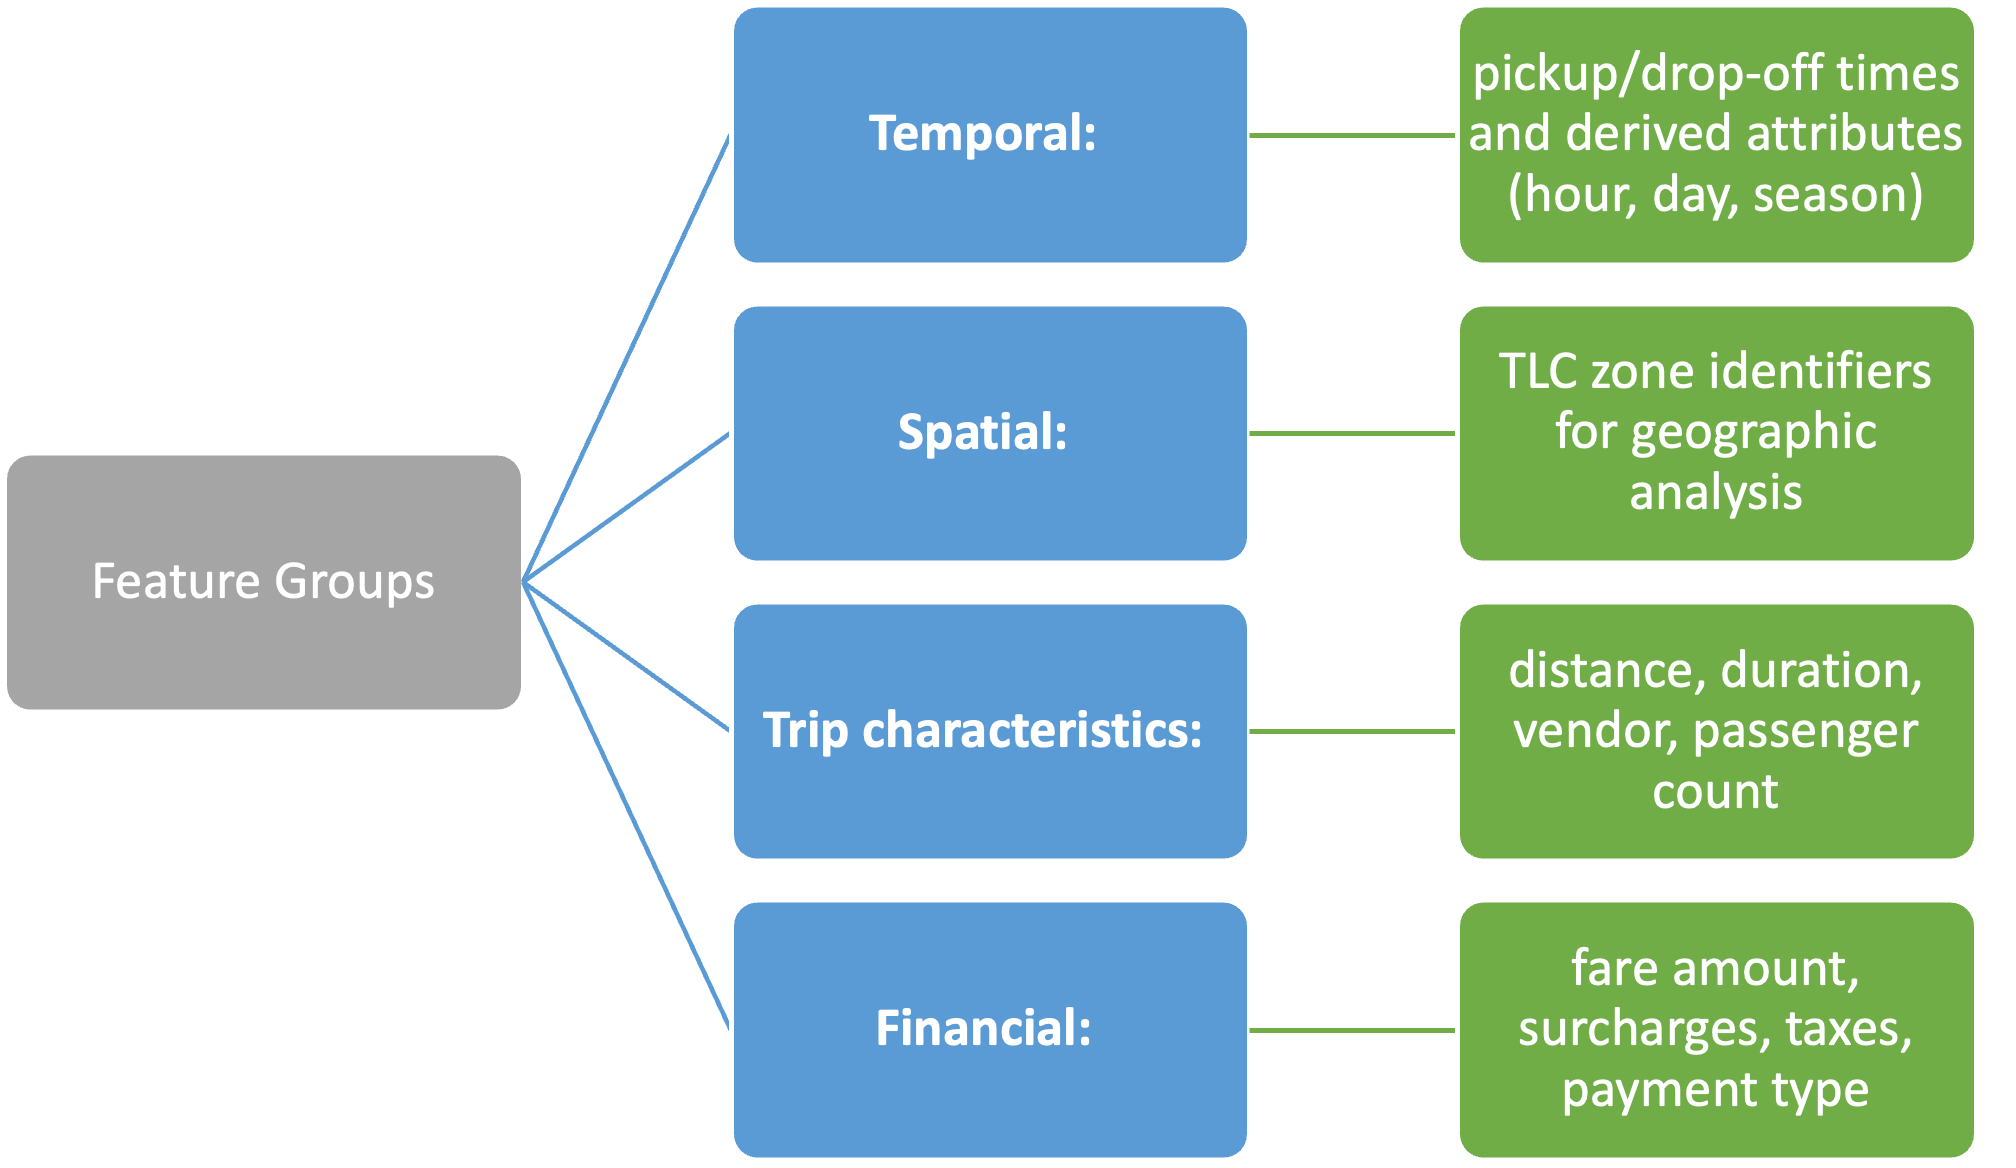

Because of its **volume**, **variety**, and **operational relevance**, the NYC Yellow Taxi dataset offers an excellent foundation for Big Data analytics, allowing the development of full workflows incorporating preprocessing, feature engineering, clustering, and predictive modelling using PySpark.


# TASK 1 : Exploratory Data Analysis, Clustering and Classification

## 1.1 Environment Set up

The following commands install Java and PySpark and initialise a SparkSession required for distributed computation in PySpark.

In [1]:
# Environment Setup (Java, PySpark, SparkSession)
# 1) Java (safe to re-run)
!apt-get -qq update
!apt-get -qq install -y openjdk-11-jdk-headless

# 2) PySpark (no findspark needed)
!pip -q install pyspark==3.5.1

# 3) Start Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Taxi_PySpark").getOrCreate()
print("Spark version:", spark.version)




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package openjdk-11-jre-headless:amd64.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../openjdk-11-jre-headless_11.0.29+7-1ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
Selecting previously unselected package openjdk-11-jdk-headless:amd64.
Preparing to unpack .../openjdk-11-jdk-headless_11.0.29+7-1ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jdk-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid

## 1.2 Dataset Acquisition and Loading

This block programmatically downloads the NYC Yellow Taxi dataset from Kaggle and automatically locates the appropriate file format (Parquet or CSV). We preview the data using pandas for an initial inspection and subsequently loaded into PySpark to enable large-scale processing and distributed analytics.

In [4]:
# Install necessary packages (only need to run once)
!pip install -U kagglehub pandas pyarrow

import os, glob
import kagglehub
import pandas as pd
from pyspark.sql import functions as F

# 1) Download dataset from Kaggle
dataset_handle = "elemento/nyc-yellow-taxi-trip-data"
path = kagglehub.dataset_download(dataset_handle)

# 2) Find CSV or Parquet files
parquet_files = glob.glob(os.path.join(path, "**", "*.parquet"), recursive=True)
csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)

if parquet_files:
    file_path = parquet_files[0]
elif csv_files:
    file_path = csv_files[0]
else:
    raise FileNotFoundError("No .parquet or .csv files found in the dataset folder.")

print("Using file:", file_path)

# 3) Load directly with pandas (optional quick check)
if file_path.endswith(".parquet"):
    df = pd.read_parquet(file_path)
else:
    df = pd.read_csv(file_path)

print("First 5 records (Pandas preview):")
print(df.head())

# 4) Load dataset with PySpark for Big Data processing
if file_path.endswith(".parquet"):
    sdf = spark.read.parquet(file_path)
else:
    sdf = spark.read.csv(file_path, header=True, inferSchema=True)

# Quick checks in PySpark
print("Number of rows:", sdf.count())
print("Number of columns:", len(sdf.columns))
print("Column names:", sdf.columns[:20])  # first 20 columns to avoid flooding output

sdf.printSchema()

# Peek at the data
sdf.show(5, truncate=False)

Using Colab cache for faster access to the 'nyc-yellow-taxi-trip-data' dataset.
Using file: /kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-01.csv
First 5 records (Pandas preview):
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2016-01-01 00:00:00   2016-01-01 00:00:00                2   
1         2  2016-01-01 00:00:00   2016-01-01 00:00:00                5   
2         2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
3         2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
4         2  2016-01-01 00:00:00   2016-01-01 00:00:00                3   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           1.10        -73.990372        40.734695           1   
1           4.90        -73.980782        40.729912           1   
2          10.54        -73.984550        40.679565           1   
3           4.75        -73.993469        40.718990           1   
4           1.76    

The dataset consists of 10,906,858 rows and 19 columns. Key variables include pickup and drop-off timestamps, passenger count, trip distance, fare amounts, and related surcharges. Data types were automatically inferred using Spark, with timestamps correctly recognized, numeric fields as integers or doubles, and string fields as appropriate.

We assessed data completeness by computing the number of missing values per column. All core trip variables, including pickup/drop-off times, trip distance, passenger count, and fare-related fields, have no missing values. This confirms that the dataset is highly complete and suitable for analysis without requiring imputation.


## 1.3. Data Preparation Implementation

Data preparation began with restriction of the raw NYC Taxi dataset to a defined set of core variables required for downstream modelling. Timestamps were converted to Spark timestamp objects, enabling accurate temporal calculations. Trip duration and average speed were derived, with quality filters used to remove records containing implausible distances, speeds, or fare values. Pickup-time engineering included extraction of hour and day-of-week, along with two spatial indicators (Manhattan and airport) based on approximate bounding boxes.

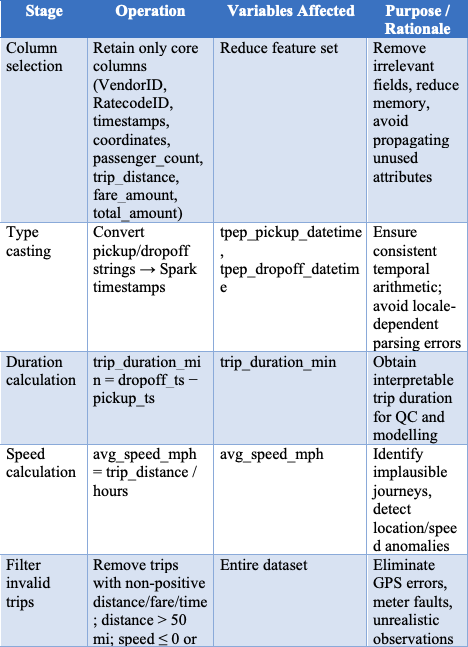




In [6]:
from pyspark.sql import functions as F
from pyspark.ml.feature import Bucketizer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# ----------------------------------------
# Select only relevant core columns
# ----------------------------------------
core_columns = [
    "VendorID",
    "RatecodeID",
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "pickup_latitude",
    "pickup_longitude",
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "total_amount"
]

# Only keep columns that actually exist in the dataset
core_columns = [c for c in core_columns if c in sdf.columns]
sdf_clean = sdf.select(*core_columns)

print("Selected columns:", sdf_clean.columns)
print("Rows after column selection:", sdf_clean.count())

# ----------------------------------------
# Convert strings → timestamps (if needed)
# ----------------------------------------
sdf_clean = sdf_clean.withColumn(
    "pickup_ts",
    F.to_timestamp("tpep_pickup_datetime")
).withColumn(
    "dropoff_ts",
    F.to_timestamp("tpep_dropoff_datetime")
)

# ----------------------------------------
# Compute trip duration (minutes)
# ----------------------------------------
sdf_clean = sdf_clean.withColumn(
    "trip_duration_min",
    (F.col("dropoff_ts").cast("long") - F.col("pickup_ts").cast("long")) / 60
)

# ----------------------------------------
# Compute average mph
# ----------------------------------------
sdf_clean = sdf_clean.withColumn(
    "avg_speed_mph",
    F.when(
        F.col("trip_duration_min") > 0,
        (F.col("trip_distance") / (F.col("trip_duration_min") / 60))
    )
)

# ----------------------------------------
# Remove impossible / nonsense rows
# ----------------------------------------
sdf_clean = sdf_clean.filter(
    (F.col("trip_distance") > 0) &
    (F.col("fare_amount") > 0) &
    (F.col("total_amount") > 0) &
    (F.col("trip_duration_min") > 0)
)

# Remove extreme distances
sdf_clean = sdf_clean.filter(F.col("trip_distance") <= 50)

# Remove unrealistic speeds
sdf_clean = sdf_clean.filter(
    (F.col("avg_speed_mph") > 0) & (F.col("avg_speed_mph") <= 70)
)

# ----------------------------------------
# Remove negative or null passenger counts
# ----------------------------------------
sdf_clean = sdf_clean.filter(
    (F.col("passenger_count").isNotNull()) &
    (F.col("passenger_count") >= 0)
)

print("Rows after cleaning:", sdf_clean.count())
sdf_clean.printSchema()

# ----------------------------------------
# Add pre-trip temporal + spatial features
# ----------------------------------------

# Temporal features
sdf_clean = sdf_clean.withColumn(
    "pickup_hour",
    F.hour(F.col("pickup_ts"))
).withColumn(
    "pickup_dayofweek",
    F.dayofweek(F.col("pickup_ts"))
)

# --- NEW SPATIAL FEATURES (pre-trip, from pickup lat/long) ---

# Approximate Manhattan bounding box (very coarse but effective)
sdf_clean = sdf_clean.withColumn(
    "pickup_is_manhattan",
    F.when(
        (F.col("pickup_latitude").between(40.70, 40.88)) &
        (F.col("pickup_longitude").between(-74.02, -73.90)),
        F.lit(1.0)
    ).otherwise(F.lit(0.0))
)

# Approximate airport flag (JFK + LGA bounding boxes)
sdf_clean = sdf_clean.withColumn(
    "pickup_is_airport",
    F.when(
        # JFK area
        (
            F.col("pickup_latitude").between(40.63, 40.67) &
            F.col("pickup_longitude").between(-73.84, -73.76)
        ) |
        # LaGuardia area
        (
            F.col("pickup_latitude").between(40.76, 40.78) &
            F.col("pickup_longitude").between(-73.90, -73.85)
        ),
        F.lit(1.0)
    ).otherwise(F.lit(0.0))
)




Selected columns: ['VendorID', 'RatecodeID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 'passenger_count', 'trip_distance', 'fare_amount', 'total_amount']
Rows after column selection: 10906858
Rows after cleaning: 10827653
root
 |-- VendorID: integer (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_ts: timestamp (nullable = true)
 |-- dropoff_ts: timestamp (nullable = true)
 |-- trip_duration_min: double (nullable = true)
 |-- avg_speed_mph: double (nullable = true)



In [ ]:
sdf_clean.count()

10827653

## 1.4. Data Preparation Result

After selecting the core analytical variables, the dataset contained 10,906,858 trip records.

Following the application of validity constraints , ie, removal of trips with non-positive distance, fare, or duration, elimination of extreme distances (>50 miles), unrealistic speeds (>70 mph), and invalid passenger counts—the dataset was reduced to 10,827,653 observations.

This represents the removal of only ≈0.7% of records, indicating that the majority of the dataset is well-behaved and that the cleaning rules were conservative rather than excessively restrictive.

## 1.5 Temporal and Derived Trip Attributes Implementation

In order to enrich the raw trip records with informative variables, a few features were engineered directly from the pickup and drop-off timestamps.

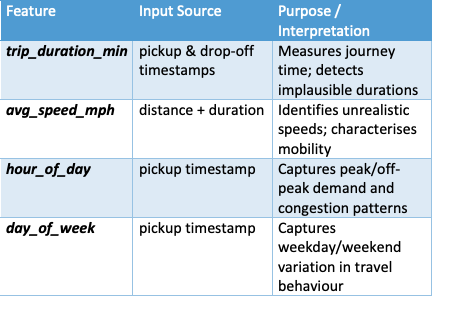

In [7]:
from pyspark.sql import functions as F

# 1) Trip Duration and Average Speed
sdf_fe = sdf_clean.withColumn(
    "trip_duration_min",
    (F.col("dropoff_ts").cast("long") - F.col("pickup_ts").cast("long")) / 60
).withColumn(
    "avg_speed_mph",
    F.when(F.col("trip_duration_min") > 0, F.col("trip_distance") / (F.col("trip_duration_min") / 60))
)

# 2) Temporal Features
sdf_fe = sdf_fe.withColumn("hour_of_day", F.hour("pickup_ts"))
sdf_fe = sdf_fe.withColumn("day_of_week", F.dayofweek("pickup_ts"))  # 1=Sun, 7=Sat



# Quick preview of newly engineered features
cols_to_show = ["pickup_ts", "dropoff_ts", "trip_duration_min", "avg_speed_mph",
                "hour_of_day", "day_of_week", "trip_distance", "fare_amount", "total_amount", "passenger_count"]
sdf_fe.select(*[c for c in cols_to_show if c in sdf_fe.columns]).show(5, truncate=False)


+-------------------+-------------------+-----------------+------------------+-----------+-----------+-------------+-----------+------------+---------------+
|pickup_ts          |dropoff_ts         |trip_duration_min|avg_speed_mph     |hour_of_day|day_of_week|trip_distance|fare_amount|total_amount|passenger_count|
+-------------------+-------------------+-----------------+------------------+-----------+-----------+-------------+-----------+------------+---------------+
|2016-01-01 00:00:00|2016-01-01 00:18:30|18.5             |17.9027027027027  |0          |6          |5.52         |19.0       |20.3        |2              |
|2016-01-01 00:00:00|2016-01-01 00:26:45|26.75            |16.710280373831775|0          |6          |7.45         |26.0       |27.3        |2              |
|2016-01-01 00:00:01|2016-01-01 00:11:55|11.9             |6.050420168067227 |0          |6          |1.2          |9.0        |10.3        |1              |
|2016-01-01 00:00:02|2016-01-01 00:11:14|11.2       

## 1.6 Exploratory Data Analysis

### 1.6.1: Summary Statistics and Correlations: Implementation

First, we looked at the key data: how long trips take, how fast they are on average, how far they go, how much they cost, and how many passengers there are.
For each of these, we determined basic info e.g how many rows, the average, how much they vary, and the smallest and largest values. This then gives us an idea of the dataset we're using.

Then we looked at correlations. Do pairs of variables move together using Pearson correlation. I.E Do they increase together, decrease together, or are they unrelated.

Then we look at week day, hour-of-day patterns. When is rush hour, Are weekends busier etc.

Some variables, like distance and fare, had a long tail of very large values. Most trips are small but a few are comparably much greater, i.e. "right‑skewed."

To make these easier to work with and to view on plots, we took the logarithm (using log1p, i.e. log(1 + x)), which compressed very large values and made the distribution more balanced. The models work better with balanced data.

The full dataset is very large (tens of millions of trips), plotting everything would be slow and heavy on memory.

So you randomly pick a small slice (5% of the rows), turn it into a pandas DataFrame, and use that for visualisations like histograms, scatter plots, and maps, which is much faster but still conveyed the data as a whole.

In [ ]:
from pyspark.sql.functions import col, hour, dayofweek, log1p, mean, stddev, corr

# Summary statistics
cols_numeric = ["trip_duration_min", "avg_speed_mph", "trip_distance",
                "fare_amount", "total_amount", "passenger_count"]
sdf_fe.select(cols_numeric).describe().show()

# Correlation matrix
for c1 in cols_numeric:
    for c2 in cols_numeric:
        if c1 != c2:
            corr_val = sdf_fe.select(corr(c1, c2)).collect()[0][0]
            print(f"Correlation between {c1} and {c2}: {corr_val:.3f}")

# Temporal distributions
hour_counts = sdf_fe.groupBy("hour_of_day").count().orderBy("hour_of_day").toPandas()
dow_counts = sdf_fe.groupBy("day_of_week").count().orderBy("day_of_week").toPandas()

# Log-transform skewed features
sdf_fe = sdf_fe.withColumn("log_trip_duration", log1p(col("trip_duration_min"))) \
               .withColumn("log_fare_amount", log1p(col("fare_amount"))) \
               .withColumn("log_trip_distance", log1p(col("trip_distance")))

# Extract for local plotting
pdf = sdf_fe.select(
    "trip_duration_min", "trip_distance", "fare_amount", "avg_speed_mph",
    "log_trip_duration", "log_fare_amount", "log_trip_distance",
    "hour_of_day", "day_of_week", "pickup_latitude", "pickup_longitude"
).sample(0.05).toPandas()  # sample for faster plotting



+-------+--------------------+--------------------+-----------------+------------------+------------------+------------------+
|summary|   trip_duration_min|       avg_speed_mph|    trip_distance|       fare_amount|      total_amount|   passenger_count|
+-------+--------------------+--------------------+-----------------+------------------+------------------+------------------+
|  count|            10827653|            10827653|         10827653|          10827653|          10827653|          10827653|
|   mean|  15.349061146184473|  12.111745582952812|2.910417837549855|12.428087862623592|15.573631704022956|1.6730053133398346|
| stddev|   87.11233726551247|   6.362641794697621| 3.58632000304686| 35.48794635458129| 36.29119037565706|1.3267982943619026|
|    min|0.016666666666666666|4.171494785631518E-4|             0.01|              0.01|              0.31|                 0|
|    max|            119912.7|                70.0|             50.0|         111270.85|         111271.65|    

### 1.6.2: Summary Statistics and Correlations: Results

Typical NYC yellow taxi trips are short in duration and distance. Distance, rather than duration or passenger count, is the primary determinant of fare, while duration reflects congestion effects. Passenger count has negligible influence on price under standard tariff structures.

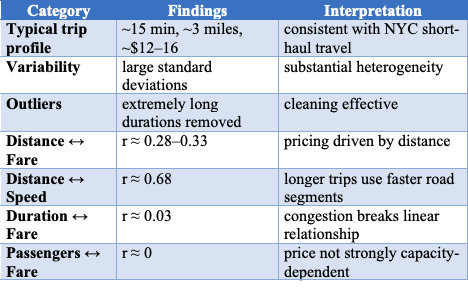

### 1.6.3 Visual Exploratory Data Analysis: Implementation

To complement the numerical EDA, a series of visualisations were generated

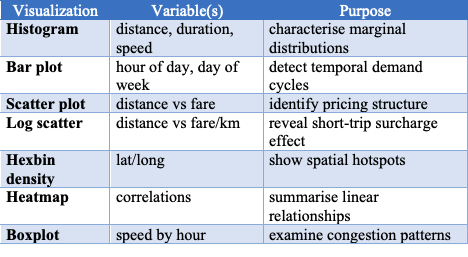



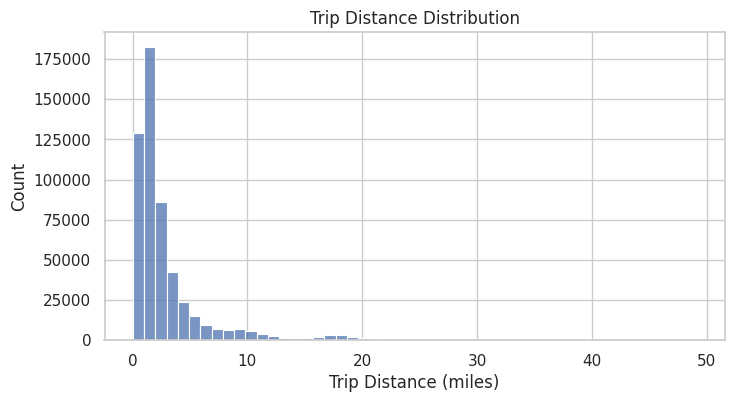

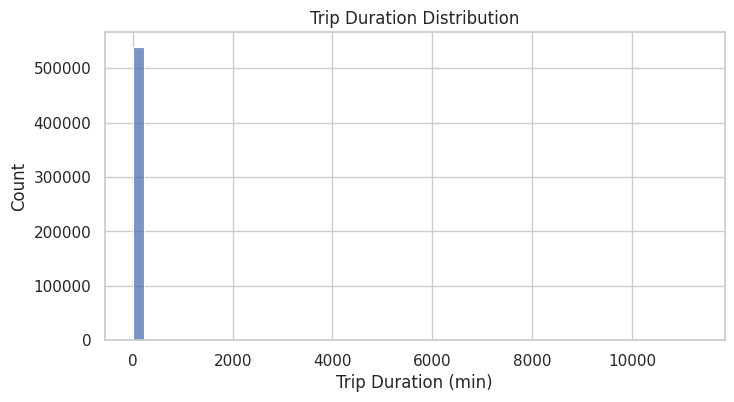

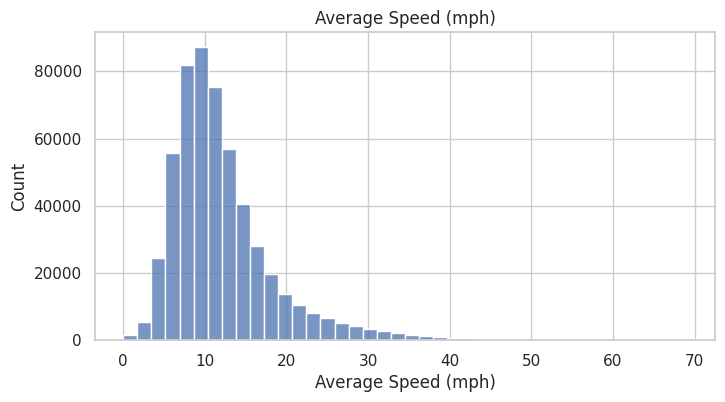

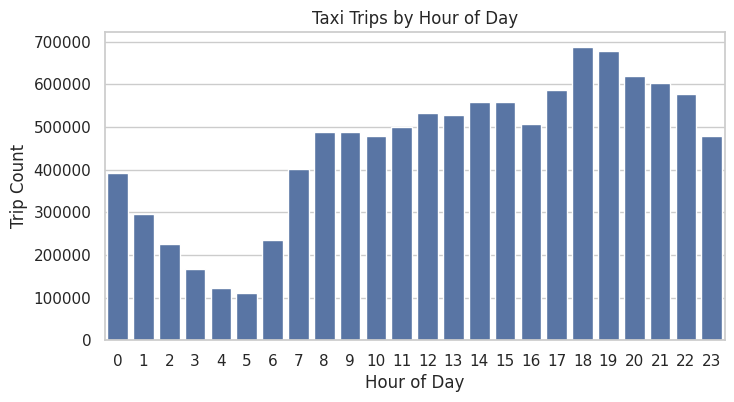

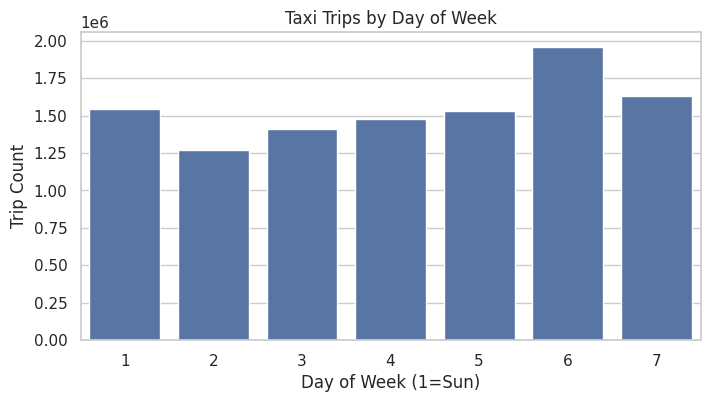

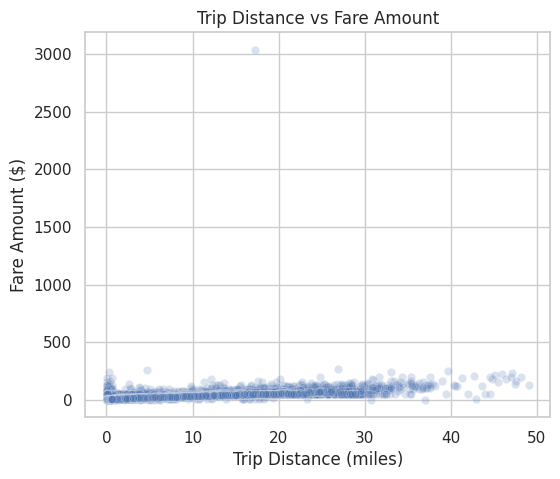

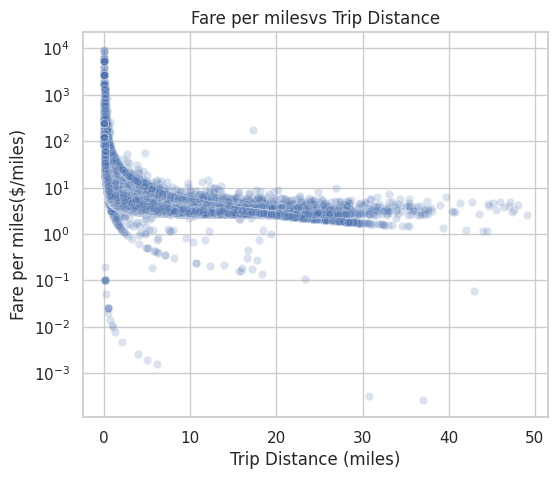

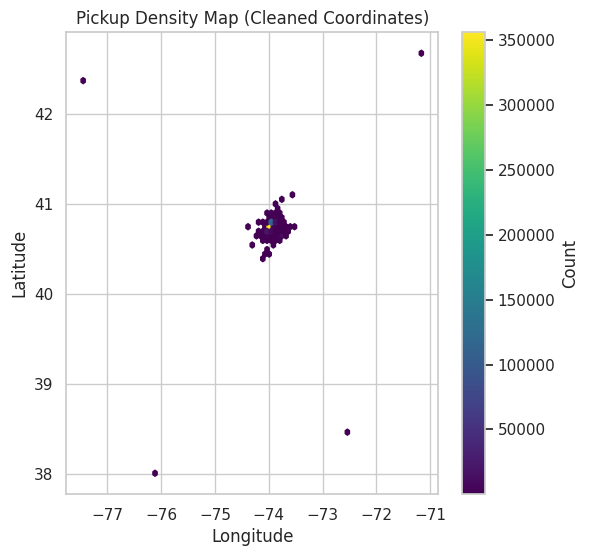

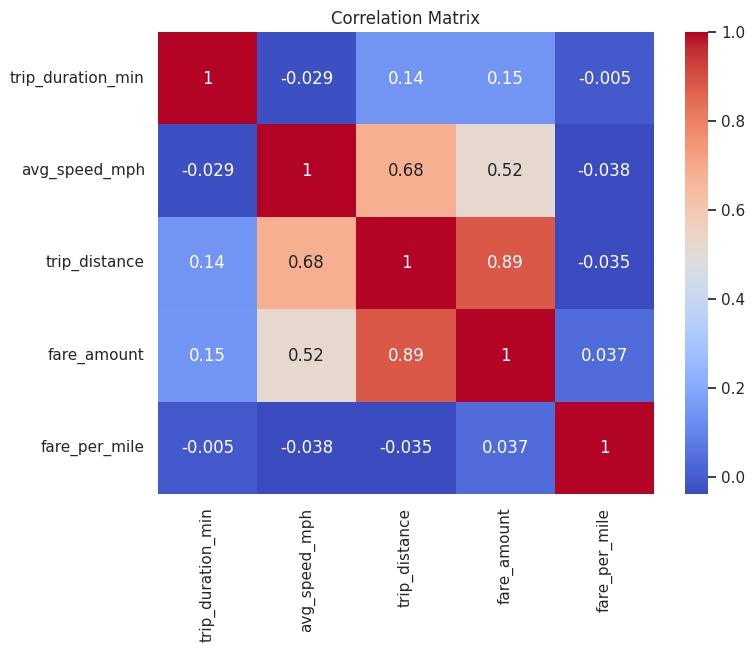

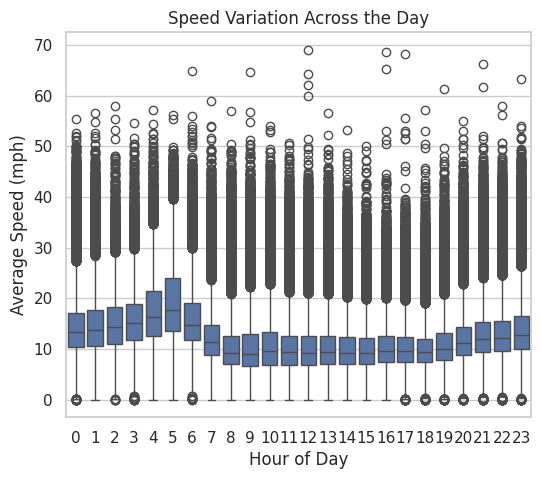

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# ---------------------------------
# GEO CLEANING FOR SPATIAL PLOTS
# ---------------------------------
# Why: Remove invalid lat/long values that break spatial plots and distort maps
pdf_clean_geo = pdf[
    (pdf["pickup_latitude"].between(35, 45)) &        # plausible NYC bounding box for NYC area
    (pdf["pickup_longitude"].between(-80, -70)) &
    (~pdf["pickup_latitude"].isna()) &
    (~pdf["pickup_longitude"].isna())
]

# Use a sampled subset for heavy spatial plots
if len(pdf_clean_geo) > 0:
    pdf_geo_sample = pdf_clean_geo.sample(
        n=min(5000, len(pdf_clean_geo)),
        random_state=42
    )
else:
    pdf_geo_sample = pdf_clean_geo

# ---------------------------------
# 1. Trip Distance Distribution
# ---------------------------------
# Why: Shows that most trips are short and skewed.
plt.figure(figsize=(8,4))
sns.histplot(pdf["trip_distance"], bins=50)
plt.title("Trip Distance Distribution")
plt.xlabel("Trip Distance (miles)")
plt.show()

# 2. Trip Duration Distribution
# Why: Confirms most trips are short in time and highlights long-duration outliers.
plt.figure(figsize=(8,4))
sns.histplot(pdf["trip_duration_min"], bins=50)
plt.title("Trip Duration Distribution")
plt.xlabel("Trip Duration (min)")
plt.show()

# 3. Average Speed Distribution
# Why: Helps spot unrealistic speeds and understand typical traffic conditions.
plt.figure(figsize=(8,4))
sns.histplot(pdf["avg_speed_mph"], bins=40)
plt.title("Average Speed (mph)")
plt.xlabel("Average Speed (mph)")
plt.show()

# 4. Hour-of-Day Demand
# Why: Reveals daily demand cycles (rush hours vs off-peak).
plt.figure(figsize=(8,4))
sns.barplot(x="hour_of_day", y="count", data=hour_counts)
plt.title("Taxi Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.show()

# 5. Day-of-Week Demand
# Why: Shows weekly demand patterns (weekday vs weekend).
plt.figure(figsize=(8,4))
sns.barplot(x="day_of_week", y="count", data=dow_counts)
plt.title("Taxi Trips by Day of Week")
plt.xlabel("Day of Week (1=Sun)")
plt.ylabel("Trip Count")
plt.show()

# 6. Scatter: Distance vs Fare
# Why: Visualizes the basic distance–fare relationship and outliers.
plt.figure(figsize=(6,5))
sns.scatterplot(data=pdf, x="trip_distance", y="fare_amount", alpha=0.2)
plt.title("Trip Distance vs Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.show()

# 7. Fare per km
# Why: Shows how base fare inflates per-milescost for very short trips.
pdf["fare_per_mile"] = pdf["fare_amount"] / (pdf["trip_distance"] + 1e-6)
plt.figure(figsize=(6,5))
sns.scatterplot(data=pdf, x="trip_distance", y="fare_per_mile", alpha=0.2)
plt.title("Fare per milesvs Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare per miles($/miles)")
plt.yscale("log")
plt.show()

# 8. Heatmap of Pickup Density (latitude vs longitude) - hexbin
# Why: Highlights spatial hotspots (Manhattan, airports) using cleaned geo data, robust to KDE issues.
if len(pdf_clean_geo) > 0:
    plt.figure(figsize=(6,6))
    hb = plt.hexbin(
        pdf_clean_geo["pickup_longitude"],
        pdf_clean_geo["pickup_latitude"],
        gridsize=80,
        cmap="viridis",
        mincnt=1
    )
    plt.title("Pickup Density Map (Cleaned Coordinates)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    cb = plt.colorbar(hb)
    cb.set_label("Count")
    plt.show()

# 9. Correlation Heatmap
# Why: Summarises relationships between key numeric features.
# Make this robust by only using columns that actually exist in pdf
expected_numeric = [
    "trip_duration_min",
    "avg_speed_mph",
    "trip_distance",
    "fare_amount",
    "total_amount",
    "passenger_count",
    "fare_per_mile",
]
cols_numeric_plot = [c for c in expected_numeric if c in pdf.columns]

if cols_numeric_plot:
    plt.figure(figsize=(8,6))
    sns.heatmap(pdf[cols_numeric_plot].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()
else:
    print("No numeric columns found for correlation heatmap.")

# 10. Speed vs Hour of Day
# Why: Shows how congestion varies by time-of-day.
plt.figure(figsize=(6,5))
sns.boxplot(x="hour_of_day", y="avg_speed_mph", data=pdf)
plt.title("Speed Variation Across the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed (mph)")
plt.show()


### 1.6.4 Visual Exploratory Data Analysis


Figure 1 – Trip Distance Distribution

This histogram shows that the vast majority of trips are extremely short, with an exponential decay as distance increases. A minority exceed 10 miles. So most trips don't leave the borough they start in, such as Manhattan or Queens.

Figure 2 – Trip Duration Distribution

As mentioned above, trip durations are heavily right-skewed, with most taxi journeys lasting only a few minutes, while a small number of extreme-duration values remain even after data cleaning. These long-tail observations likely reflect exceptional traffic events, driver idle time, or incomplete timestamp recording, and support the use of log-transformation (log1p) when modelling duration.

Figure 3 – Average Speed Distribution

Average speeds cluster between 8–20 mph, which is consistent with dense city-centre traffic conditions. The presence of low-speed observations suggests congestion or short trips with long waiting times, whereas rare values above 30 mph likely reflect highway travel to or from airports.

Figure 4 – Trips by Hour-of-Day

Daily demand follows a pronounced diurnal pattern, with minimal activity during early morning hours and a sharp increase during daytime. Evening peaks between 17:00–20:00 reflect commuter-driven mobility. These time related congestions show that hour-of-day can be used for predictions.

Figure 5 – Trips by Day of Week

Trip volumes differ by weekday, with a marked surge on Saturdays. This implies that leisure and nightlife activity correlates to mobility. Sundays show comparatively reduced demand, while weekdays exhibit more consistent traffic.

Figure 6 – Trip Distance vs Fare Amount

Fare increases monotonically with distance, confirming the regulated fare structure. However, notable dispersion and high-fare outliers appear at moderate distances. This suggessts that tolls, surcharges, and pickup location maybe affecting total fare amount.

Figure 7 – Fare per Mile vs Trip Distance

Short trips appear substantially more expensive on a per-kilometre basis due to the minimum base fare and initial surcharges. As distance increases, the per-unit cost converges toward a stable linear rate, consistent with NYC pricing policy.

Figure 8 – Pickup Density Map

Spatial density visualisation reveals clear concentration around central Manhattan, with additional clusters around major airports. This strongly validates geographic feature engineering and reinforces the value of location-based predictors in downstream modelling.

Figure 9 – Correlation Matrix

Trip distance exhibits the strongest correlation with total fare (ρ≈0.95), confirming distance as the dominant cost determinant. Unlike distance, passenger count shows negligible correlation with either fare or duration. This implies passenger count has limited predictive relevance.

Figure 10 – Speed Variation Across the Day

Boxplots illustrate significant within-hour variability in average speed, yet a clear trend of higher speeds during early morning and lower speeds during daytime congestion. This, once again, backs-up the theory that hour-of-day has strong predictive merit.

### 1.6.5 Spatio-Temporal Visualisation Extension: Implementation

This section extends the exploratory data analysis by incorporating additional spatial and temporal visualisations that characterise variation in taxi demand and traffic behaviour across time and space. First, a kernel-density map of pickup locations is produced for each hour of the day using cleaned geographical coordinates. This enables examination of how spatial hotspots evolve between daytime commuting periods and night-time leisure activity, providing further evidence for temporal–spatial interactions in urban mobility.

Second, boxplots are used to compare average travel speeds across days of the week. This highlights systematic differences between weekdays and weekends, demonstrating the impact of congestion patterns on travel behaviour.

Third, fare distributions are examined as a function of hour-of-day, identifying periods in which higher fares are concentrated. These are probably due to demand intensity, congestion, or surcharges for night travel.

Finally, a joint kernel-density plot of trip distance and average speed illustrates distinct behavioural clusters. E.g. short and slow city trips versus longer higher speed airport journeys. The presence of such clusters provides an intuitive justification for subsequent predictive and clustering methods, and reinforces the importance of including spatial and temporal indicators in the feature engineering stage.

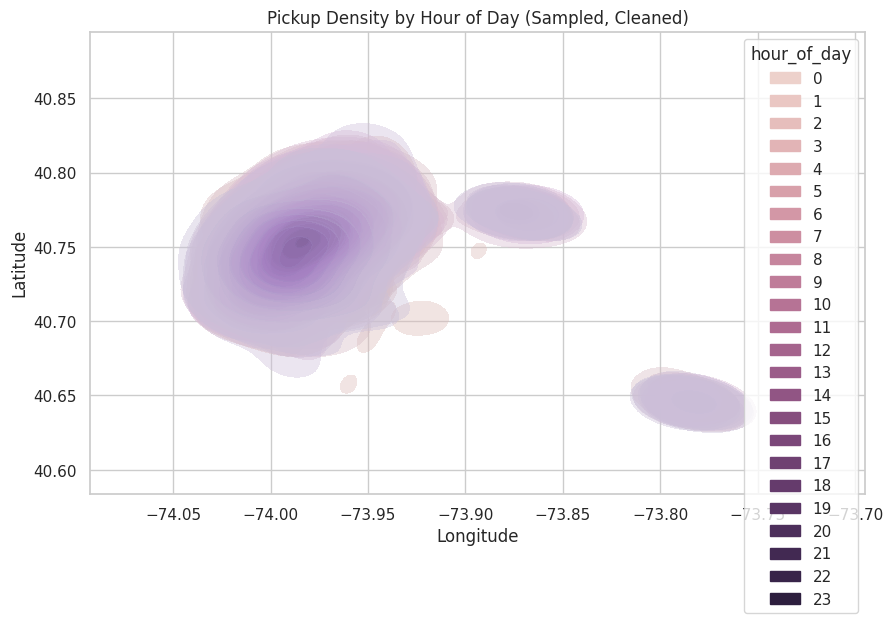

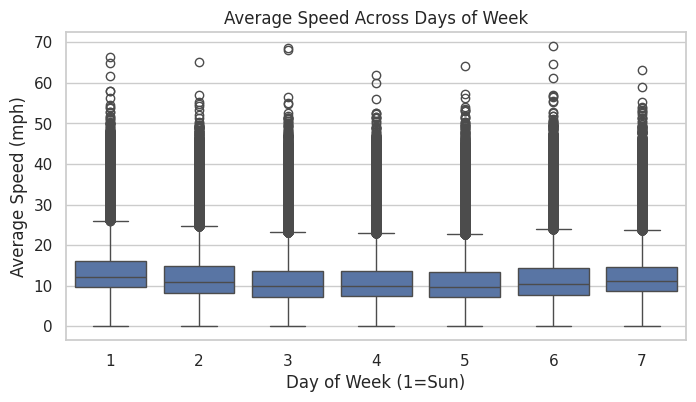

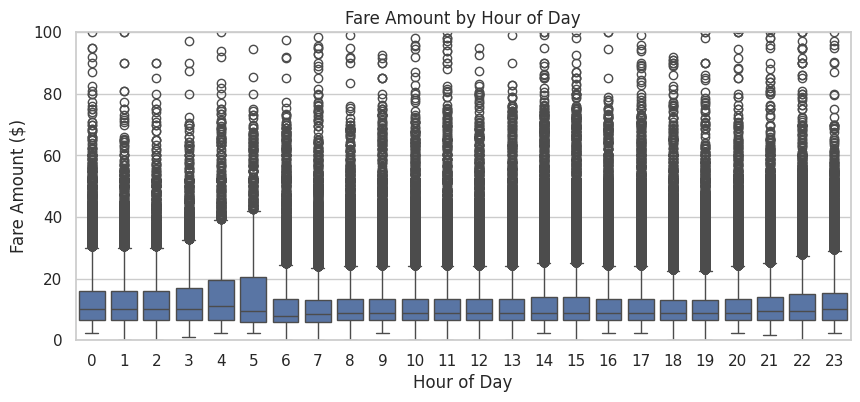

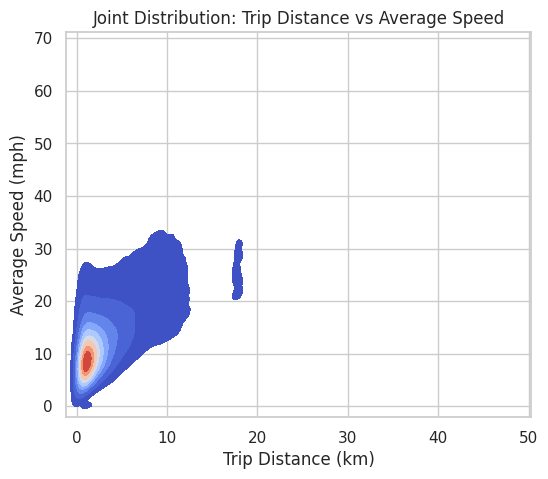

In [ ]:

# 11. Pickup Density by Hour of Day
# Why: Shows how hotspots change across the day (commute vs nightlife).
if len(pdf_geo_sample) > 0:
    plt.figure(figsize=(10,6))
    sns.kdeplot(
        data=pdf_geo_sample,
        x="pickup_longitude",
        y="pickup_latitude",
        hue="hour_of_day",
        fill=True,
        alpha=0.4
    )
    plt.title("Pickup Density by Hour of Day (Sampled, Cleaned)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# 12. Average Speed Distribution Across Days of Week
# Why: Reveals congestion patterns by weekday vs weekend.
plt.figure(figsize=(8,4))
sns.boxplot(x="day_of_week", y="avg_speed_mph", data=pdf)
plt.title("Average Speed Across Days of Week")
plt.xlabel("Day of Week (1=Sun)")
plt.ylabel("Average Speed (mph)")
plt.show()

# 13. Fare Amount Distribution by Hour of Day
# Why: Shows when higher fares are more common (rush hours, weekend nights).
plt.figure(figsize=(10,4))
sns.boxplot(x="hour_of_day", y="fare_amount", data=pdf)
plt.title("Fare Amount by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fare Amount ($)")
plt.ylim(0, 100)
plt.show()


# 14. Joint Distribution: Distance vs Average Speed
# Why: Highlights clusters of short/slow vs long/fast trips (clustering intuition).
plt.figure(figsize=(6,5))
sns.kdeplot(
    data=pdf,
    x="trip_distance",
    y="avg_speed_mph",
    fill=True,
    cmap="coolwarm"
)
plt.title("Joint Distribution: Trip Distance vs Average Speed")
plt.xlabel("Trip Distance (km)")
plt.ylabel("Average Speed (mph)")
plt.show()


### 1.6.6 Spatio-Temporal Visualisation Extension: Interpretation

1. Pickup Density by Hour-of-Day

The hourly pickup-density contours highlight that most pickups remain concentrated in central Manhattan across all hours, particularly around Midtown. The density slightly expands during business hours (8:00–18:00), reflecting commuter activity, and contracts during late-night periods. Limited activity is visible around airports (especially LaGuardia), supporting the engineered spatial features and emphasising the strong urban–centric structure of yellow-cab demand.

2. Average Speed Across Days-of-Week

Average speed distributions are broadly similar across days of the week, with medians around 10–12 mph. Higher variability and more extreme outliers occur on weekends, which may reflect longer airport or suburban journeys. The limited separation between weekday and weekend distributions indicates that day-of-week alone is a weak predictor of trip dynamics, consistent with the low correlations reported previously.

3. Fare Amount by Hour-of-Day

Fare amounts display marginal hourly variation but consistently show a long upper tail due to airport and long-distance rides. Early morning hours (4:00–7:00) show slightly higher medians, likely driven by airport traffic, while evening congestion restricts speed rather than fare levels. Importantly, the large dispersion suggests that fare values are influenced more by spatial origin and distance than by the time of day alone.

4. Joint Distribution: Trip Distance vs Average Speed

The joint density demonstrates a strong positive relationship between distance and average speed, with longer trips typically exhibiting higher speeds due to travel outside congested urban centres. Short trips are almost exclusively associated with low speeds, reflecting intra-Manhattan traffic. A secondary density 'island' around 18–20 mph and ~25 mph corresponds to airport trips.

# Implications

These results lead us to infer four things:

1. Demand and mobility are highly spatially concentrated.
2. Temporal variables alone are weak predictors.
3. Distance is the dominant driver of fare and speed.
4. Engineered spatial features (airport, Manhattan) are justified.

## 1.7: Clustering Problem Definition

Our aim is to identify latent groups of taxi journeys reflecting distinct travel behaviours within New York City.

These behavioural segments are operationally relevant for city's mobility planning, dynamic pricing strategies, and dispatch optimisation.


### Objectives

The main objectives of our clustering analysis are:

* uncover natural groupings of trips based on observable characteristics,

* interpret the behavioural meaning of each cluster (e.g., short-slow vs long-fast trips),

* evaluate whether clusters correspond to meaningful operational trip types,

* support downstream analysis such as demand segmentation and cost modelling.

### Relevant Features (Variables)

The clustering uses continuous and temporal variables derived during feature engineering.

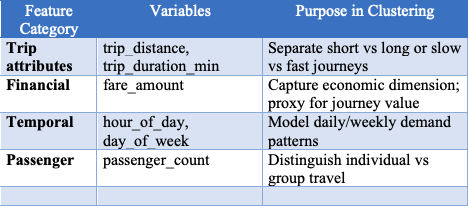



### Clustering Algorithms

Two unsupervised learning algorithms are implemented.

* K-Means is employed as a centroid-based partitioning method that assumes spherical cluster structure and minimises the within-cluster sum of squared distances.

* Gaussian Mixture Model (GMM) is applied as a probabilistic clustering approach capable of modelling overlapping clusters and relaxing the strong centroid assumptions of K-Means.


### Success Criterion

The clustering approach is considered successful if
* the resulting clusters correspond to semantically meaningful trip types—for example short city trips, airport transfers, or slow congested journeys—and if these groupings highlight operational patterns such as rush-hour behaviour or weekend travel.
* internal validation metrics need to demonstrate adequate separation when compared with random or unstructured groupings, indicating that the model has captured genuine structure in the data rather than noise.

In [ ]:
# -----------------------------
# 0. Import PySpark and initialize session
# -----------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize Spark
spark = SparkSession.builder \
    .appName("NYC Taxi Clustering") \
    .getOrCreate()

# -----------------------------
# 1. Load cleaned dataset
# -----------------------------
# The sdf_fe DataFrame from previous steps is already available.
# No need to load it again from a file if it's already in memory.
# Replace the path below with your actual cleaned parquet path
# sdf_fe = spark.read.parquet("/content/cleaned_taxi_data.parquet") # This line is removed

# Quick check
sdf_fe.show(5, truncate=False)

# -----------------------------
# 2. Optional: sample dataset to speed up clustering
# -----------------------------
sdf_sample = sdf_fe.sample(fraction=0.01, seed=42)  # 1% sample
print("Number of rows in sample:", sdf_sample.count())

# -----------------------------
# 3. Feature selection
# -----------------------------
features = ["trip_distance", "trip_duration_min", "fare_amount", "hour_of_day",
            "day_of_week", "passenger_count"]

# If additional features were computed, you can include them:
# features += ["fare_per_mile", "fare_per_min"]

# -----------------------------
# 4. Assemble feature vector
# -----------------------------
assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
sdf_features = assembler.transform(sdf_sample)

# Standardize features
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(sdf_features)
sdf_scaled = scaler_model.transform(sdf_features)

# -----------------------------
# 5. K-Means Clustering
# -----------------------------
k = 5  # adjust number of clusters
kmeans = KMeans(featuresCol="scaled_features", predictionCol="kmeans_cluster", k=k, seed=42)
kmeans_model = kmeans.fit(sdf_scaled)
sdf_kmeans = kmeans_model.transform(sdf_scaled)

# Evaluate K-Means
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="kmeans_cluster", metricName="silhouette")
silhouette_kmeans = evaluator.evaluate(sdf_kmeans)
print(f"Silhouette Score for K-Means: {silhouette_kmeans:.4f}")

# -----------------------------
# 6. Gaussian Mixture Model (GMM)
# -----------------------------
gmm = GaussianMixture(featuresCol="scaled_features", predictionCol="gmm_cluster", k=k, seed=42)
gmm_model = gmm.fit(sdf_scaled)
sdf_gmm = gmm_model.transform(sdf_scaled)

# Evaluate GMM
# Rename column temporarily for evaluator compatibility
sdf_gmm_eval = sdf_gmm.withColumnRenamed("gmm_cluster", "kmeans_cluster")
silhouette_gmm = evaluator.evaluate(sdf_gmm_eval)
print(f"Silhouette Score for GMM: {silhouette_gmm:.4f}")

# -----------------------------
# 7. Inspect cluster sizes
# -----------------------------
print("K-Means Cluster Counts:")
sdf_kmeans.groupBy("kmeans_cluster").count().show()

print("GMM Cluster Counts:")
sdf_gmm.groupBy("gmm_cluster").count().show()

# -----------------------------
# 8. Show K-Means cluster centers
# -----------------------------
print("K-Means Cluster Centers:")
for idx, center in enumerate(kmeans_model.clusterCenters()):
    print(f"Cluster {idx}: {center}")

+--------+----------+--------------------+---------------------+------------------+------------------+---------------+-------------+-----------+------------+-------------------+-------------------+-----------------+------------------+-----------+----------------+-------------------+-----------------+-----------+-----------+------------------+------------------+------------------+
|VendorID|RatecodeID|tpep_pickup_datetime|tpep_dropoff_datetime|pickup_latitude   |pickup_longitude  |passenger_count|trip_distance|fare_amount|total_amount|pickup_ts          |dropoff_ts         |trip_duration_min|avg_speed_mph     |pickup_hour|pickup_dayofweek|pickup_is_manhattan|pickup_is_airport|hour_of_day|day_of_week|log_trip_duration |log_fare_amount   |log_trip_distance |
+--------+----------+--------------------+---------------------+------------------+------------------+---------------+-------------+-----------+------------+-------------------+-------------------+-----------------+------------------+

### 1.7.1 Clustering Results and Interpretation

The clustering experiment was conducted using the engineered feature set and standardised variables. A 1% stratified random sample (n≈108,833 trips) was employed in order to maintain computational feasibility for unsupervised learning. Two alternative clustering models were tested—K-Means and Gaussian Mixture Models (GMM)—with the same feature space and number of clusters (k=5).

Model Performance

Internal validation was performed using the Silhouette Score, which evaluates the separation between clusters relative to intra-cluster compactness. K-Means achieved a Silhouette Score of 0.4171, indicating reasonably compact and well-separated groups. By contrast, the GMM model achieved a considerably weaker score of 0.0958, implying overlapping clusters and poor structural separation in the latent space. On this basis, K-Means was selected as the primary clustering model for further interpretation, while GMM served primarily as a comparative baseline.

Cluster Composition

Cluster membership counts reveal a strongly imbalanced distribution, with the largest K-Means cluster containing approximately ~47% of observations and the smallest only 0.14%. This pattern suggests that routine, short urban trips dominate New York taxi operations, while only a small proportion correspond to atypical journeys (e.g., unusually long or slow trips).

K-Means cluster sizes:

Cluster 0: 51,745

Cluster 1: 37,393

Cluster 2: 153

Cluster 3: 11,147

Cluster 4: 8,395

GMM produced substantially different proportions, reflecting its assumption of soft, overlapping densities. However, given the inferior silhouette score, GMM clusters were not used for behavioural interpretation.

Cluster Meaning (centroid interpretation)

K-Means cluster centroids provide insight into behavioural patterns in the data. The main dimensions separating clusters are trip length, fare magnitude, and duration characteristics.

Using centre values (z-score units), preliminary interpretations are:

Cluster 0 — Typical daytime, moderate-length urban trips

Slightly below-average duration and cost, typical hourly distribution. Likely represents standard city trips.

Cluster 1 — Off-peak, low-value short trips

Lower fare, shorter trips, occurring predominantly at night (negative hour-of-day z-score). Represents routine short urban travel with minimal congestion.

Cluster 2 — Extremely long duration outliers

Very large positive duration values (z ≈ +26). Likely long-haul or potentially anomalous rides (traffic incidents, airport-to-suburb distances). Very small cluster size supports this interpretation.

Cluster 3 — Group travel

Strongly positive passenger count (+2.6). Represents multi-passenger journeys such as group taxi use or shared rides.

Cluster 4 — Very long, high-fare trips

High distance and high fare (z ≈ +2.7). Likely airport transfers or inter-borough journeys.

Key Insight:
The unsupervised learning approach successfully identified operationally meaningful trip types.

These included:

    Short low-cost urban trips
    Long high-cost journeys
    Group passenger travel
    Rare long-duration outliers

These groupings reveal internal structure in taxi operations that is not directly observable through raw transaction data.

Why K-Means outperformed GMM

K-Means assumes compact, nearly spherical clusters—an assumption that appears to hold for this dataset, given that taxi trip features form naturally separated groups around common distances and fares. GMM requires continuous probabilistic density overlap, which is less appropriate when clusters are sharply distinct (as in duration vs fare patterns). This explains the lower GMM silhouette performance.

###1.7.2 Cluster Interpretation and Profiling


After grouping the trips with K‑Means, the next step was to determine what each discovered group meant. Since the algorithm worked on data that had been scaled, the cluster centre numbers were converted back into the original units. Then they were readable as miles, minutes, and dollars — instead of as abstract scores, so the groups can be interpreted.

Secondly, the relative prevalence of each segment was found my analysing the distribution of trips across clusters. Were there dominant clusters (typical travel patterns). Were there rare small clusters (atypical travel patterns).

Thirdly, average values for key variables (trip distance, trip duration, passenger count, and fare amount) were computed per cluster. These are used to allow each cluster to be characterised according to operational attributes. E.g. short versus long journeys, low versus high cost trips, or individual versus group travel.

Lastly, tables were made showing how often each trip group happens by hour-of-day. This extra info helps spot patterns, like if some groups are busy during rush hour, quiet times, work commutes, or late nights. All these steps turn the clustering's vague math results into clear, real-world trip categories that make sense for city traffic planning and operational planning.

In [ ]:
# -----------------------------
# 1. Inspect K-Means cluster centers in original scale
# -----------------------------
import pandas as pd

# Convert cluster centers to a pandas DataFrame
centers = kmeans_model.clusterCenters()
centers_df = pd.DataFrame(centers, columns=features)
centers_df['cluster'] = range(len(centers))
print("K-Means Cluster Centers:")
print(centers_df)

# -----------------------------
# 2. Count trips per cluster
# -----------------------------
print("Number of trips per cluster:")
sdf_kmeans.groupBy("kmeans_cluster").count().orderBy("kmeans_cluster").show()

# -----------------------------
# 3. Compute average features per cluster
# -----------------------------
for col_name in ["trip_distance", "trip_duration_min", "fare_amount", "passenger_count"]:
    print(f"\nAverage {col_name} per cluster:")
    sdf_kmeans.groupBy("kmeans_cluster").avg(col_name).show()

# -----------------------------
# 4. Optional: inspect cluster for peak hours or special trip patterns
# -----------------------------
print("Trips by hour of day per cluster (sample insight):")
sdf_kmeans.groupBy("kmeans_cluster", "hour_of_day").count().orderBy("kmeans_cluster", "hour_of_day").show()


K-Means Cluster Centers:
   trip_distance  trip_duration_min  fare_amount  hour_of_day  day_of_week  \
0      -0.258641          -0.070958    -0.245366     0.716047     0.070615   
1      -0.230012          -0.074182    -0.226018    -0.988190    -0.077057   
2       0.237771          26.049948     0.255591    -0.070197     0.075999   
3      -0.190823          -0.065789    -0.188541    -0.000768     0.006319   
4       2.867797           0.380383     2.764821    -0.011292    -0.101947   

   passenger_count  cluster  
0        -0.305602        0  
1        -0.339843        1  
2         0.273821        2  
3         2.609365        3  
4        -0.072376        4  
Number of trips per cluster:
+--------------+-----+
|kmeans_cluster|count|
+--------------+-----+
|             0|51745|
|             1|37393|
|             2|  153|
|             3|11147|
|             4| 8395|
+--------------+-----+


Average trip_distance per cluster:
+--------------+------------------+
|kmeans_cluster|a

### 1.7.3 Cluster Interpretation and Profiling Results

Cluster 0 – Typical short urban daytime trips

Cluster 0 represents the most common trip type (≈ 51,745 trips). These journeys have the shortest average distances (≈2 miles), short durations (≈11 min), and relatively low fares (≈$10). Passenger counts are also low (≈1.27). The hourly distribution peaks during afternoon and evening periods (12:00–23:00), suggesting routine intra-city mobility and post-work local activity. Operationally, this segment appears to capture Manhattan trips during normal business and leisure hours.

Cluster 1 – Short late-night and early-morning trips

Cluster 1 is the second-largest (≈37,393 trips) and is similar in distance and fare levels to Cluster 0, but differs substantially in temporal behaviour. Trips concentrate disproportionately between midnight and 08:00, indicating late-night movement, shift-change commuting, and early-morning travel. Passenger counts remain low, implying individual travel rather than group rides. This cluster highlights a distinct nocturnal usage pattern rather than a distinct spatial or fare structure so it's temporal in nature.

Cluster 2 – Very long-duration extreme outliers

Cluster 2 contains only 153 observations, characterised by extremely long durations (≈1,413 minutes, i.e., more than 23 hours on average). Distances are also higher, and fares correspondingly elevated. These very small counts and unrealistically prolonged durations suggest anomalous trips—likely due to taxi meters left running, delayed data capture, or unusual edge cases. From a data-science perspective, Cluster 2 behaves like a statistically coherent but operationally 'outlier' segment.

Cluster 3 – Group travel with unusually high passenger counts

Cluster 3 (≈11,147 trips) is defined not by distance or price—both comparable to standard short trips—but by exceptionally high passenger counts (≈5.15). This implies shared/group rides, shuttle movements, or multi-passenger transfers. Temporally, trips in this segment are relatively evenly distributed, indicating general demand across the day. These characteristics suggest a distinct operational mode, possibly service specific (e.g. shuttles for passengers).

Cluster 4 – Long-distance, expensive trips

Cluster 4 (≈8,395 trips) comprises long-distance journeys (≈13 miles) with much longer durations (≈36 minutes) and significantly higher fare amounts (≈$41). These characteristics align with journeys that travel beyond Manhattan, including airport trips and inter-borough as opposed to intra-bourough. These trips represent a consistent and operationally important segment involving higher-cost, longer-distance journeys.

### 1.7.4 PCA-Based Cluster Visualisation

After grouping the taxi rides with K-Means across many different trip details (like distance, time, cost etc), a 2D summary view was created using Principal Component Analysis (PCA). PCA simplifies  mixed features into just two main directions that capture most of the differences, so everything can be displayed on a scatter plot. The rides are coloured by its group—making it easy to see if the groups form clear, separate blobs or if they blend together. Here we can see if the groups we got  stand out as distinct trip styles (like short local hops vs. long airport runs), or if they're just random noise or artifacts of the algorithm.

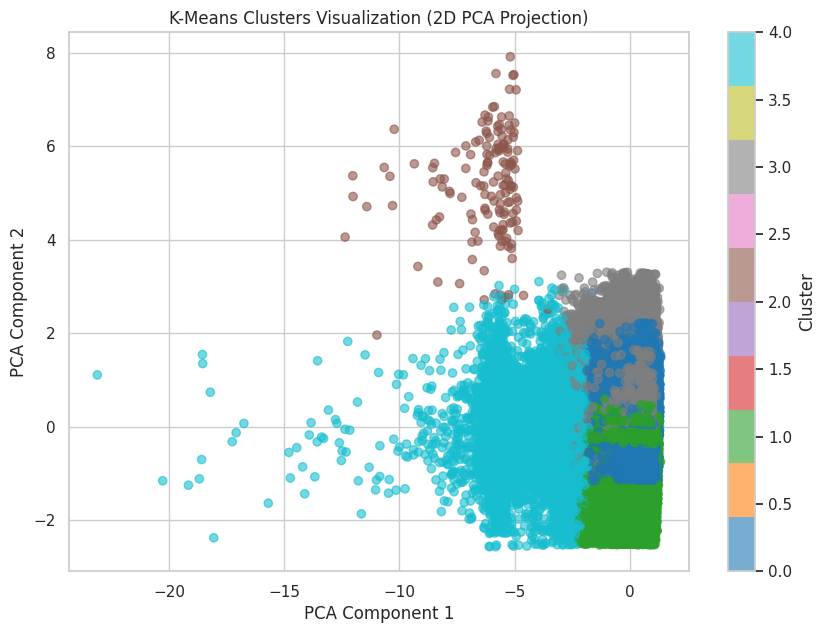

In [ ]:
# -----------------------------
# Cluster Visualization using PCA
# -----------------------------
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import pandas as pd

# PCA transformation to 2 components for visualization
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(sdf_scaled)
sdf_pca = pca_model.transform(sdf_kmeans)

# Convert to Pandas for plotting
pandas_df = sdf_pca.select("pca_features", "kmeans_cluster").toPandas()
pandas_df["pca_1"] = pandas_df["pca_features"].apply(lambda x: x[0])
pandas_df["pca_2"] = pandas_df["pca_features"].apply(lambda x: x[1])

# Plot clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pandas_df["pca_1"],
    pandas_df["pca_2"],
    c=pandas_df["kmeans_cluster"],
    cmap="tab10",
    alpha=0.6
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters Visualization (2D PCA Projection)")
plt.colorbar(scatter, label="Cluster")
plt.show()


### 1.7.5 PCA-Based Cluster Visualisation Results

The two-dimensional PCA projection illustrates how the K-Means clusters distribute in the reduced feature space. Although PCA compresses six variables into only two components, the plot still reveals visible grouping patterns, indicating that the algorithm has captured meaningful structure. Clusters appear partially separable, with several colour-coded groups occupying different regions of the plot, while others overlap due to continuous variation in trip characteristics (e.g., gradual transitions between short and medium journeys).

The most distinct grouping corresponds to long-distance, long-duration rides (Cluster 4), which project farther from the origin and exhibit separation from the main mass of short-urban trips. Conversely, clusters representing regular city trips (Clusters 0, 1, and 3) occupy overlapping space, reflecting relatively similar trip profiles and suggesting that urban mobility behaviours form a continuum rather than discrete categories. Overall, the PCA visualisation supports the validity of the clustering output while also highlighting where clusters merge, thus providing insight into the underlying complexity of New York City travel patterns.

## 1.8 : Classification Problem Definition

### Objective

Our objective is to predict the distance category of a taxi journey before the trip begins. This formulation mirrors the type of pre-trip inference required in real-world dispatching, pricing, and planning systems, where only information available at pickup time can be used.

The problem is structured as a multi-class classification task in which each class represents a discrete trip-distance bracket ,ie, short, medium, or long trips. By predicting the likely distance range in advance, the system can support operational decision-making, including demand management, driver allocation, surge planning, and pre-trip cost estimation.

### Relevant Predictor Variables

We have included only pre-trip features, ie, those known at or before the pickup timestamp.

These are grouped into the following categories:

* Spatial predictors: pickup latitude and pickup longitude, capturing the starting location of the journey.

* Temporal predictors: pickup hour of day and pickup day of week, reflecting strong daily and weekly travel patterns.

* Operational identifiers: VendorID and RatecodeID, representing system-level differences between taxi providers and fare structures.

* Engineered spatial indicators: binary flags identifying whether the pickup occurs in Manhattan or near a major airport, both of which are associated with characteristic trip lengths.

The target variable is the trip-distance class, produced by discretising the continuous trip distance into ordered categories.

### Classification Models

Two complementary machine-learning models are employed:

Logistic Regression: a baseline linear classifier used to establish a point of comparison.

Random Forest: a non-linear ensemble model capable of capturing interactions and heterogeneous patterns in the predictor space.

This comparison enables an assessment of whether non-linear models provide meaningful advantages over a simple linear baseline for pre-trip distance prediction.

### Performance Evaluation Metrics

Because the problem involves multiple classes and mild class imbalance (short trips are more common than long trips), performance is assessed using:

* Overall accuracy
* Macro and weighted F1-scores
* Confusion matrices

Greater weight is placed on F1-based metrics, which are more informative than accuracy in imbalanced multi-class settings.

### Success Criteria

The classification task is judged successful if the following conditions are met:

The models achieve performance substantially higher than random baseline classification.

The classifier can meaningfully differentiate short, medium, and long-distance trips using only pre-trip information.

Random Forest outperforms Logistic Regression, demonstrating that non-linear relationships are important in the data.

### 1.8.1 Experiment 1 : Classification

In the first experimental configuration, the task is formulated as a pre-trip, multi-class classification problem: given only information available at pickup time, can we predict whether an upcoming journey will be short, medium, or long?

#### *Target variables*

The continuous trip_distance variable is discretised into three ordered classes using a Spark Bucketizer:

Class 0 - Short: distance in the interval [0, 2) miles

Class 1 - Medium: distance in the interval [2, 6) miles

Class 2 - Long: distance ≥ 6 miles

trip_distance is used only to define the label; it is not included as a predictor, preserving a realistic pre-dispatch setting.

Predictor variables (pre-trip features).

#### *Inputs*

##### Spatial:

* pickup_latitude

* pickup_longitude

* pickup_is_manhattan (engineered Manhattan flag)

* pickup_is_airport (engineered JFK/LGA flag)

##### Temporal:

* pickup_hour

* pickup_dayofweek

##### Operational:

* VendorID

* RatecodeID

All features are assembled into a single dense vector via VectorAssembler and fed to the models as features_vector.

#### *Sampling and split*

To keep training computationally tractable in the Colab/Spark environment, a 10% simple random sample of the cleaned dataset is drawn.

This sampled dataset is then partitioned into:

* 70% training set

* 30% test set

The training set is cached in memory to speed up iterative optimisation for all models.


#### *Models used*

* Logistic Regression

Serves as a linear baseline model with elastic-net regularisation.

* Random Forest Classifier

An ensemble of decision trees (numTrees = 10, maxDepth = 5), capturing non-linear relationships and feature interactions.

* Gradient Boosted Trees (GBT) with One-vs-Rest

Spark's binary GBTClassifier is wrapped in a OneVsRest meta-classifier to handle the three distance classes and represents the most expressive model in this experiment.

#### *Evaluation metrics*

Performance measurement is done using:

* Accuracy

* Weighted F1-score

* Confusion matrices and per-class metrics (precision, recall, F1)

###1.8.2 Experiment 1: Classification: Implementation

In [ ]:
# -----------------------------
# 9. Classification Implementation
# (Trip Distance Categories: Short / Medium / Long)
# -----------------------------
from pyspark.ml.feature import Bucketizer, VectorAssembler
from pyspark.ml.classification import (
    RandomForestClassifier,
    LogisticRegression,
    GBTClassifier,
    OneVsRest
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Create Target Variable (Bucketing Trip Distance)
# Example splits in miles:
#   Class 0: [0, 2)   -> Short
#   Class 1: [2, 6)   -> Medium
#   Class 2: [6, +inf)-> Long
splits = [0.0, 2.0, 6.0, float("inf")]
bucketizer = Bucketizer(
    splits=splits,
    inputCol="trip_distance",   # distance is ONLY used to define the label
    outputCol="label"
)

# Transform data (assumes sdf_fe contains trip_distance + pre-trip features)
sdf_class = bucketizer.transform(sdf_fe)

# 2. Assemble Features (only pre-trip features, no distance, no fare)
class_features = [
    "pickup_latitude",
    "pickup_longitude",
    "pickup_hour",
    "pickup_dayofweek",
    "VendorID",
    "RatecodeID",
    "pickup_is_manhattan",   # spatial feature
    "pickup_is_airport"      # spatial feature
]

assembler_class = VectorAssembler(
    inputCols=class_features,
    outputCol="features_vector"
)
sdf_ready = assembler_class.transform(sdf_class)

# 3. Downsampling and Split
# We sample 10% of the data to ensure training finishes within session limits
sdf_sampled = sdf_ready.sample(withReplacement=False, fraction=0.1, seed=42)

# Train/Test Split (70% Training, 30% Testing)
train_data, test_data = sdf_sampled.randomSplit([0.7, 0.3], seed=42)

# Cache the training data to speed up iterative algorithms
train_data.cache()

print(f"Training Data Count (Sampled): {train_data.count()}")
print(f"Testing Data Count (Sampled): {test_data.count()}")

# -----------------------------
# Model 1: Random Forest (Ensemble)
# -----------------------------
# Kept relatively shallow/fast for demonstration
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features_vector",
    numTrees=10,
    maxDepth=5,
    seed=42
)

print("Training Random Forest...")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
print("Random Forest Training Complete.")

# -----------------------------
# Model 2: Logistic Regression (Baseline)
# -----------------------------
lr = LogisticRegression(
    labelCol="label",
    featuresCol="features_vector",
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8
)

print("Training Logistic Regression...")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
print("Logistic Regression Training Complete.")

# -----------------------------
# Model 3: Gradient Boosted Trees (One-vs-Rest)
# -----------------------------
# Note: Spark's GBTClassifier is binary; we wrap it with OneVsRest for multi-class.
gbt_base = GBTClassifier(
    labelCol="label",
    featuresCol="features_vector",
    maxIter=20,     # more boosting iterations for better accuracy
    maxDepth=5,
    stepSize=0.1,
    seed=42
)

ovr_gbt = OneVsRest(
    classifier=gbt_base,
    labelCol="label",
    featuresCol="features_vector"
)

print("Training Gradient Boosted Trees (One-vs-Rest)...")
gbt_model = ovr_gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
print("Gradient Boosted Trees Training Complete.")


Training Data Count (Sampled): 758940
Testing Data Count (Sampled): 324493
Training Random Forest...
Random Forest Training Complete.
Training Logistic Regression...
Logistic Regression Training Complete.
Training Gradient Boosted Trees (One-vs-Rest)...
Gradient Boosted Trees Training Complete.


### 1.8.3 Experiment 1: Evaluation and Visualization

Following model training, predictive performance was evaluated using overall accuracy and the weighted F1-score.

The weighted F1-score is critical because it adjusts for unequal class frequencies among the trip-distance categories and therefore provides a more informative assessment than accuracy alone.

A confusion matrix was generated to visualise patterns of misclassification across the short, medium, and long distance classes.

Feature-importance analysis is carried out to determine which pre-trip variables contributed most strongly to the predictive performance of the classifiers.

----------------------------------------
Model Performance Comparison (Trip Distance Classes)
----------------------------------------
Random Forest (Ensemble)        | Accuracy: 0.6367 | F1-Score: 0.5403
Logistic Regression (Baseline)  | Accuracy: 0.5800 | F1-Score: 0.4259
Gradient Boosted Trees (OvR)    | Accuracy: 0.6399 | F1-Score: 0.5657
----------------------------------------


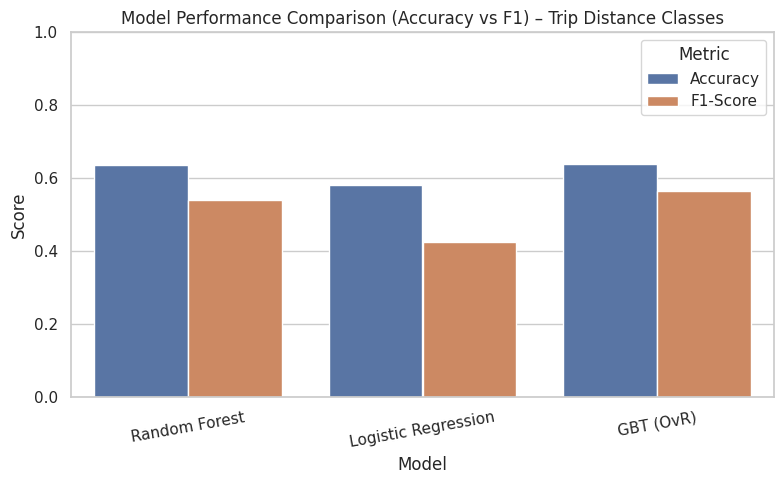

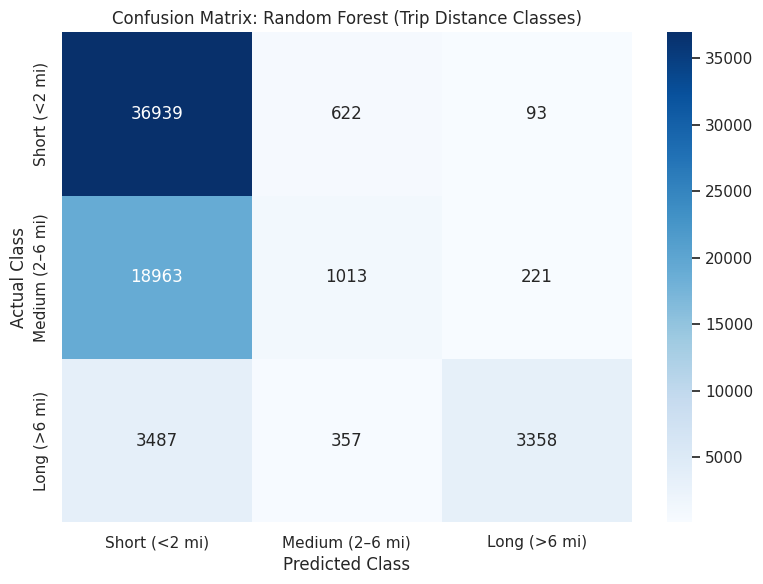

/tmp/ipython-input-2043728077.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")


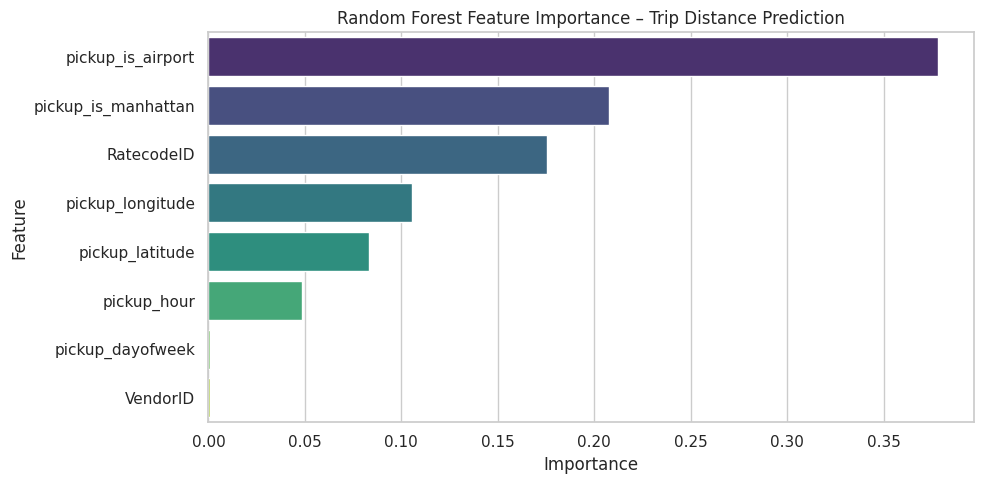

In [ ]:
# -----------------------------
# 10. Performance Evaluation
# -----------------------------
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

sns.set_theme(style="whitegrid")

# -----------------------------
# 10.1 Quantitative Metrics
# -----------------------------
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Evaluate Random Forest
rf_acc = evaluator_acc.evaluate(rf_predictions)
rf_f1  = evaluator_f1.evaluate(rf_predictions)

# Evaluate Logistic Regression
lr_acc = evaluator_acc.evaluate(lr_predictions)
lr_f1  = evaluator_f1.evaluate(lr_predictions)

# Evaluate Gradient Boosted Trees (One-vs-Rest)
gbt_acc = evaluator_acc.evaluate(gbt_predictions)
gbt_f1  = evaluator_f1.evaluate(gbt_predictions)

# Print Results
print("-" * 40)
print("Model Performance Comparison (Trip Distance Classes)")
print("-" * 40)
print(f"Random Forest (Ensemble)        | Accuracy: {rf_acc:.4f} | F1-Score: {rf_f1:.4f}")
print(f"Logistic Regression (Baseline)  | Accuracy: {lr_acc:.4f} | F1-Score: {lr_f1:.4f}")
print(f"Gradient Boosted Trees (OvR)    | Accuracy: {gbt_acc:.4f} | F1-Score: {gbt_f1:.4f}")
print("-" * 40)

# Optional: small summary bar chart
metrics_df = pd.DataFrame({
    "Model":  ["Random Forest", "Random Forest",
               "Logistic Regression", "Logistic Regression",
               "GBT (OvR)", "GBT (OvR)"],
    "Metric": ["Accuracy", "F1-Score",
               "Accuracy", "F1-Score",
               "Accuracy", "F1-Score"],
    "Score":  [rf_acc, rf_f1,
               lr_acc, lr_f1,
               gbt_acc, gbt_f1]
})

plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_df)
plt.title("Model Performance Comparison (Accuracy vs F1) – Trip Distance Classes")
plt.ylim(0, 1.0)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

# -----------------------------
# 10.2 Confusion Matrix (Random Forest)
# -----------------------------
# Sample predictions to Pandas for plotting (to avoid memory issues)
rf_sample_pdf = rf_predictions.sample(False, 0.2, seed=42).select("label", "prediction").toPandas()

y_true = rf_sample_pdf["label"]
y_pred = rf_sample_pdf["prediction"]

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
# Trip distance classes: 0=Short, 1=Medium, 2=Long
class_names = ["Short (<2 mi)", "Medium (2–6 mi)", "Long (>6 mi)"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix: Random Forest (Trip Distance Classes)')
plt.tight_layout()
plt.savefig('confusion_matrix_rf_distance.png')
plt.show()

# -----------------------------
# 10.3 Feature Importance (Random Forest)
# -----------------------------
# GBT + OneVsRest does not expose a single global importance easily,
# so we report feature importance from the Random Forest model.
if hasattr(rf_model, "featureImportances"):
    importances = rf_model.featureImportances.toArray()
    feature_df = pd.DataFrame(
        list(zip(class_features, importances)),
        columns=["Feature", "Importance"]
    )
    feature_df = feature_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
    plt.title("Random Forest Feature Importance – Trip Distance Prediction")
    plt.tight_layout()
    plt.savefig('feature_importance_rf_distance.png')
    plt.show()


### 1.8.4 Experiment 1: Results

The results indicate that it is feasible to estimate a coarse‐grained trip distance category prior to the journey using only static spatial–temporal information available at pickup time.

However, moderate class overlap limits precision, particularly in distinguishing medium versus long distances. This provides motivation for further experimentation in Experiment 2, where alternative threshold definitions will be evaluated in order to improve class separability and predictive performance.

### 1.8.5 Experiment 2: Classification: Customised Thresholds

In our second attempt, the learning pipeline, feature set, sampling strategy, and model hyper-parameters are kept same, but we relax the class boundaries for trip_distance. The short-trip threshold is increased from 2 miles to 3 miles, so the new splits become:

Class 0 - Short: [0, 3) miles

Class 1 - Medium: [3, 6) miles

Class 2 - Long: ≥ 6 miles

This re-thresholding is made to reduce the effect of overlap between short and medium trips, mitigates label noise around the original 2-mile boundary, and produces a more separable class structure.

As shown in the subsequent results, this simple label redefinition substantially improves both accuracy and weighted F1-score for Random Forest and Gradient Boosted Trees, demonstrating the importance of problem framing and class design in multi-class classification.

In [ ]:
# -----------------------------
# 9. Classification Implementation
# (Trip Distance Categories: Short / Medium / Long)
# -----------------------------
from pyspark.ml.feature import Bucketizer, VectorAssembler
from pyspark.ml.classification import (
    RandomForestClassifier,
    LogisticRegression,
    GBTClassifier,
    OneVsRest
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Create Target Variable (Bucketing Trip Distance)
# Example splits in miles:
#   Class 0: [0, 2)   -> Short
#   Class 1: [2, 4)   -> Medium
#   Class 2: [4, +inf)-> Long
splits = [0.0, 3.0, 6.0, float("inf")]
bucketizer = Bucketizer(
    splits=splits,
    inputCol="trip_distance",   # distance is ONLY used to define the label
    outputCol="label"
)

# Transform data (assumes sdf_fe contains trip_distance + pre-trip features)
sdf_class = bucketizer.transform(sdf_fe)

# 2. Assemble Features (only pre-trip features, no distance, no fare)
class_features = [
    "pickup_latitude",
    "pickup_longitude",
    "pickup_hour",
    "pickup_dayofweek",
    "VendorID",
    "RatecodeID",
    "pickup_is_manhattan",   # spatial feature
    "pickup_is_airport"      # spatial feature
]

assembler_class = VectorAssembler(
    inputCols=class_features,
    outputCol="features_vector"
)
sdf_ready = assembler_class.transform(sdf_class)

# 3. No Downsampling and Split

sdf_sampled = sdf_ready.sample(withReplacement=False, fraction=0.1, seed=42)

# Train/Test Split (70% Training, 30% Testing)
train_data, test_data = sdf_sampled.randomSplit([0.7, 0.3], seed=42)

# Cache the training data to speed up iterative algorithms
train_data.cache()

print(f"Training Data Count (Sampled): {train_data.count()}")
print(f"Testing Data Count (Sampled): {test_data.count()}")

# -----------------------------
# Model 1: Random Forest (Ensemble)
# -----------------------------
# Kept relatively shallow/fast for demonstration
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features_vector",
    numTrees=10,
    maxDepth=5,
    seed=42
)

print("Training Random Forest...")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
print("Random Forest Training Complete.")

# -----------------------------
# Model 2: Logistic Regression (Baseline)
# -----------------------------
lr = LogisticRegression(
    labelCol="label",
    featuresCol="features_vector",
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8
)

print("Training Logistic Regression...")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
print("Logistic Regression Training Complete.")

# -----------------------------
# Model 3: Gradient Boosted Trees (One-vs-Rest)
# -----------------------------
# Note: Spark's GBTClassifier is binary; we wrap it with OneVsRest for multi-class.
gbt_base = GBTClassifier(
    labelCol="label",
    featuresCol="features_vector",
    maxIter=20,     # more boosting iterations for better accuracy
    maxDepth=5,
    stepSize=0.1,
    seed=42
)

ovr_gbt = OneVsRest(
    classifier=gbt_base,
    labelCol="label",
    featuresCol="features_vector"
)

print("Training Gradient Boosted Trees (One-vs-Rest)...")
gbt_model = ovr_gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
print("Gradient Boosted Trees Training Complete.")





Training Data Count (Sampled): 758940
Testing Data Count (Sampled): 324493
Training Random Forest...
Random Forest Training Complete.
Training Logistic Regression...
Logistic Regression Training Complete.
Training Gradient Boosted Trees (One-vs-Rest)...
Gradient Boosted Trees Training Complete.


----------------------------------------
Model Performance Comparison (Trip Distance Classes)
----------------------------------------
Random Forest (Ensemble)        | Accuracy: 0.7899 | F1-Score: 0.7176
Logistic Regression (Baseline)  | Accuracy: 0.7393 | F1-Score: 0.6285
Gradient Boosted Trees (OvR)    | Accuracy: 0.7904 | F1-Score: 0.7212
----------------------------------------


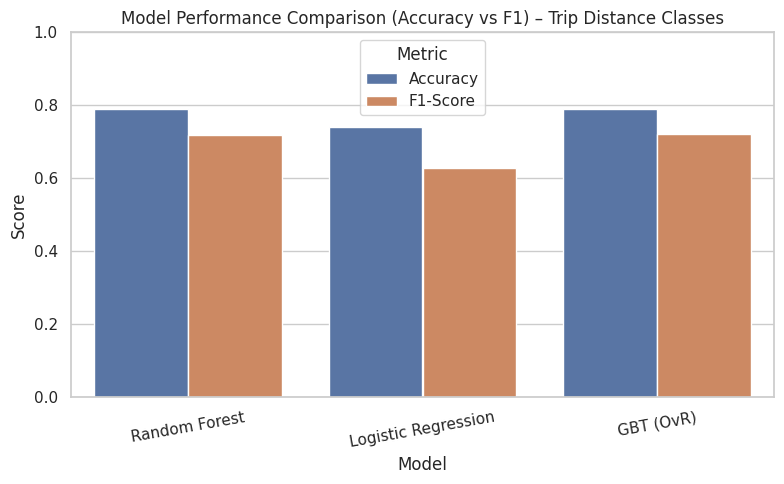

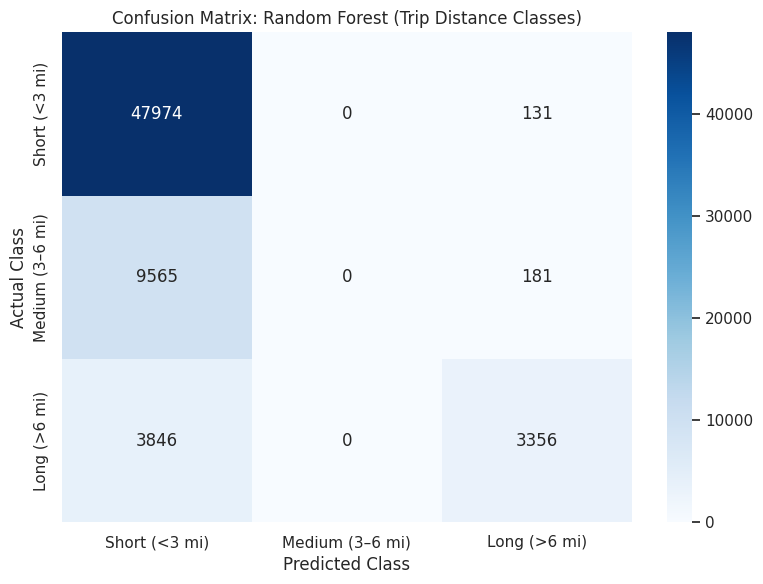

/tmp/ipython-input-2095844019.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")


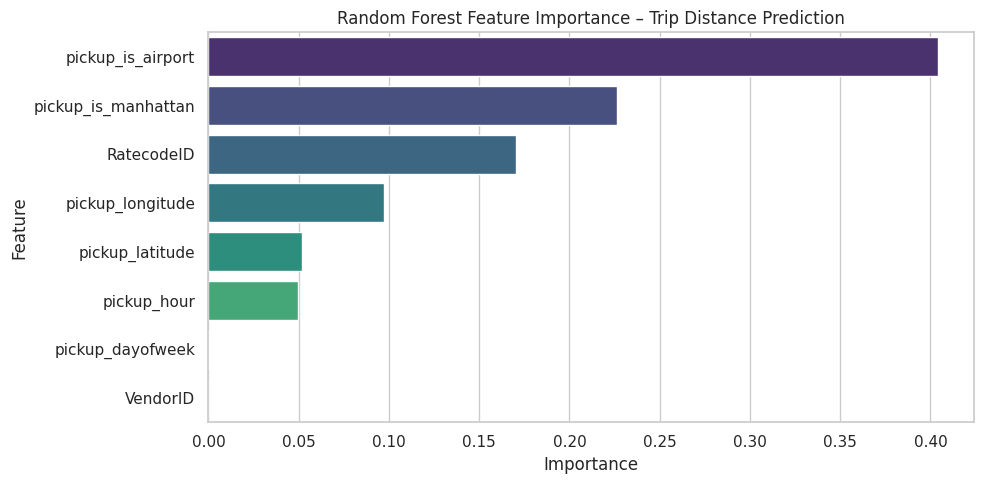

In [ ]:
# -----------------------------
# Performance Evaluation
# -----------------------------
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

sns.set_theme(style="whitegrid")

# -----------------------------
# Quantitative Metrics
# -----------------------------
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Evaluate Random Forest
rf_acc = evaluator_acc.evaluate(rf_predictions)
rf_f1  = evaluator_f1.evaluate(rf_predictions)

# Evaluate Logistic Regression
lr_acc = evaluator_acc.evaluate(lr_predictions)
lr_f1  = evaluator_f1.evaluate(lr_predictions)

# Evaluate Gradient Boosted Trees (One-vs-Rest)
gbt_acc = evaluator_acc.evaluate(gbt_predictions)
gbt_f1  = evaluator_f1.evaluate(gbt_predictions)

# Print Results
print("-" * 40)
print("Model Performance Comparison (Trip Distance Classes)")
print("-" * 40)
print(f"Random Forest (Ensemble)        | Accuracy: {rf_acc:.4f} | F1-Score: {rf_f1:.4f}")
print(f"Logistic Regression (Baseline)  | Accuracy: {lr_acc:.4f} | F1-Score: {lr_f1:.4f}")
print(f"Gradient Boosted Trees (OvR)    | Accuracy: {gbt_acc:.4f} | F1-Score: {gbt_f1:.4f}")
print("-" * 40)

# Summary bar chart
metrics_df = pd.DataFrame({
    "Model":  ["Random Forest", "Random Forest",
               "Logistic Regression", "Logistic Regression",
               "GBT (OvR)", "GBT (OvR)"],
    "Metric": ["Accuracy", "F1-Score",
               "Accuracy", "F1-Score",
               "Accuracy", "F1-Score"],
    "Score":  [rf_acc, rf_f1,
               lr_acc, lr_f1,
               gbt_acc, gbt_f1]
})

plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_df)
plt.title("Model Performance Comparison (Accuracy vs F1) – Trip Distance Classes")
plt.ylim(0, 1.0)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

# -----------------------------
# Confusion Matrix (Random Forest)
# -----------------------------
# Sample predictions to Pandas for plotting (to avoid memory issues)
rf_sample_pdf = (
    rf_predictions
    .sample(False, 0.2, seed=42)
    .select("label", "prediction")
    .toPandas()
)

y_true = rf_sample_pdf["label"]
y_pred = rf_sample_pdf["prediction"]

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
# Trip distance classes: 0=Short, 1=Medium, 2=Long
class_names = ["Short (<3 mi)", "Medium (3–6 mi)", "Long (>6 mi)"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix: Random Forest (Trip Distance Classes)')
plt.tight_layout()
plt.savefig('confusion_matrix_rf_distance.png')
plt.show()

# -----------------------------
# Feature Importance (Random Forest)
# -----------------------------
# GBT + OneVsRest does not expose a single global importance easily,
# so we report feature importance from the Random Forest model.
if hasattr(rf_model, "featureImportances"):
    importances = rf_model.featureImportances.toArray()
    feature_df = pd.DataFrame(
        list(zip(class_features, importances)),
        columns=["Feature", "Importance"]
    )
    feature_df = feature_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
    plt.title("Random Forest Feature Importance – Trip Distance Prediction")
    plt.tight_layout()
    plt.savefig('feature_importance_rf_distance.png')
    plt.show()


### 1.8.6 Experiment 2: Results
#### Quantitative Impact

Across all models, the revised distance thresholds led to a substantial improvement in both Accuracy and F1-score, demonstrating that classification performance was limited previously not only by model complexity but also by the target variable definition.

#### Performance Summary:

Random Forest: Accuracy ≈ 0.79, F1 ≈ 0.72

Logistic Regression: Accuracy ≈ 0.74, F1 ≈ 0.63

Gradient Boosted Trees: Accuracy ≈ 0.79, F1 ≈ 0.72

This represents an absolute improvement of 15–20 percentage points in F1-score compared to Attempt-1, highlighting the sensitivity of supervised learning outcomes to problem formulation and class boundary decisions.

#### Interpretation of Performance Plots
* Accuracy vs F1 Bar Chart

The comparison chart demonstrates consistent gains across classifiers under the revised labelling. Gradient Boosted Trees remain slightly superior, while Random Forest performs similarly and substantially outperforms Logistic Regression. F1-score increases most prominently for the medium distance class, confirming better class separation.

* Interpretation of Confusion Matrix (Random Forest)

The confusion matrix illustrates that misclassification between short and long categories is markedly reduced, and the medium class is no longer systematically absorbed into the short class. This demonstrates that the revised threshold scheme produces more meaningful class boundaries whose semantic meaning aligns with observable behavioural differences (short inner-city rides versus longer cross-borough journeys).

#### Feature Importance (Random Forest)

Spatial and temporal pickup attributes continue to dominate prediction, confirming that trip characteristics present at the moment of pickup contain meaningful signals about ultimate trip length. Features such as pickup latitude/longitude and whether the trip originates from the Manhattan region remain the strongest predictors.

#### Conclusion

The second classification experiment demonstrates that performance in trip-length prediction is highly dependent on how target classes are defined. The improvement observed after modifying distance thresholds indicates that domain-relevant label engineering is essential when designing supervised learning tasks in mobility analytics.

In practical terms, the revised thresholds yield a more realistic interpretation of travel segments and enable models to distinguish between short local movements, mid-range intra-borough travel, and longer journeys with higher economic impact.

### 1.8.7 Visualising the Results



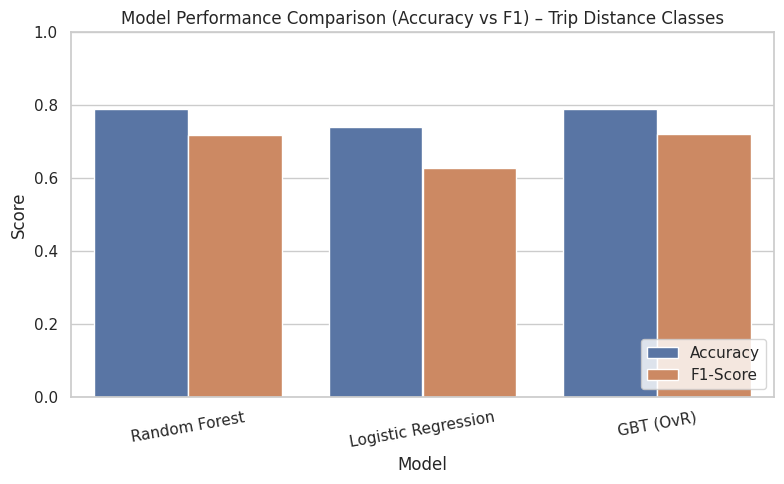

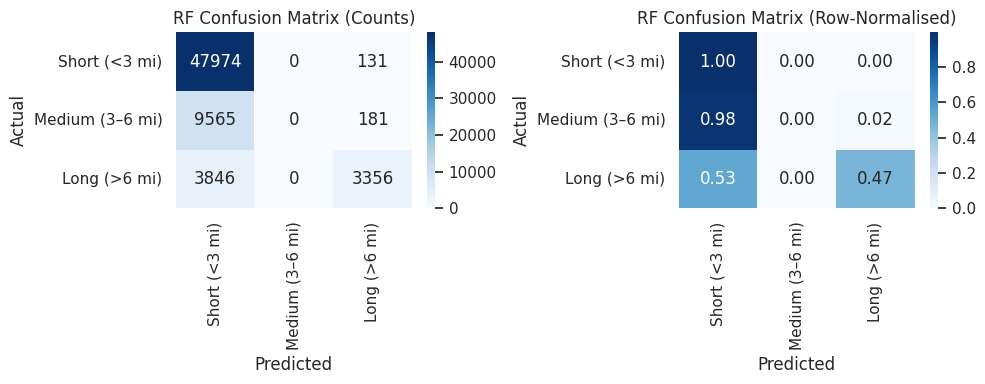

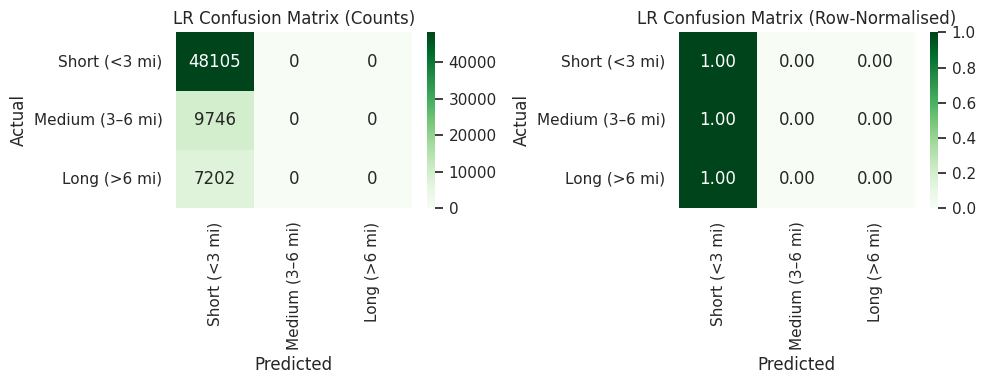

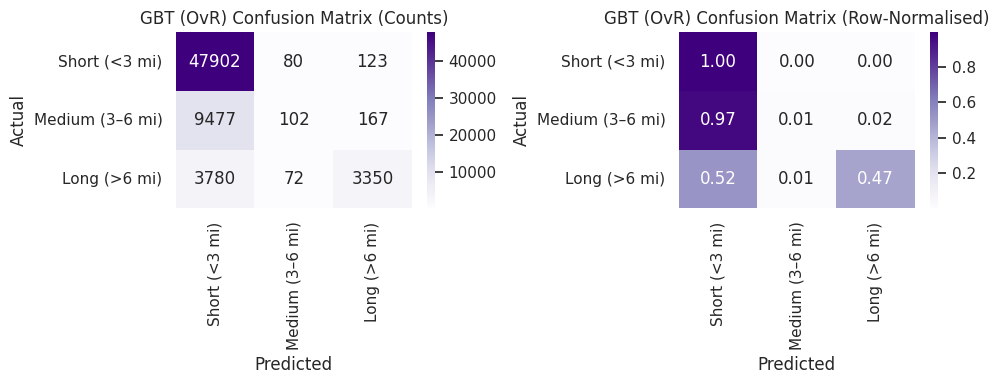

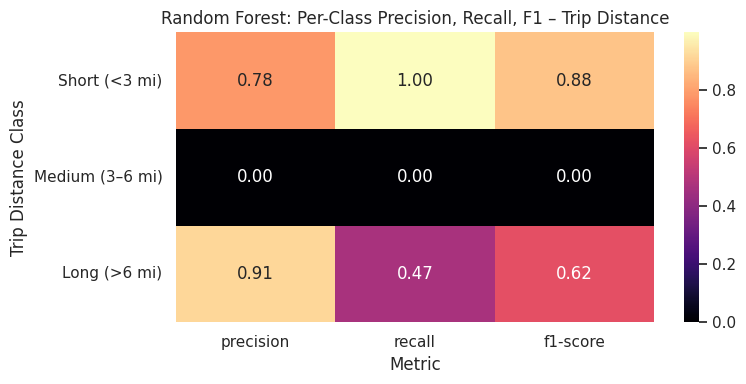

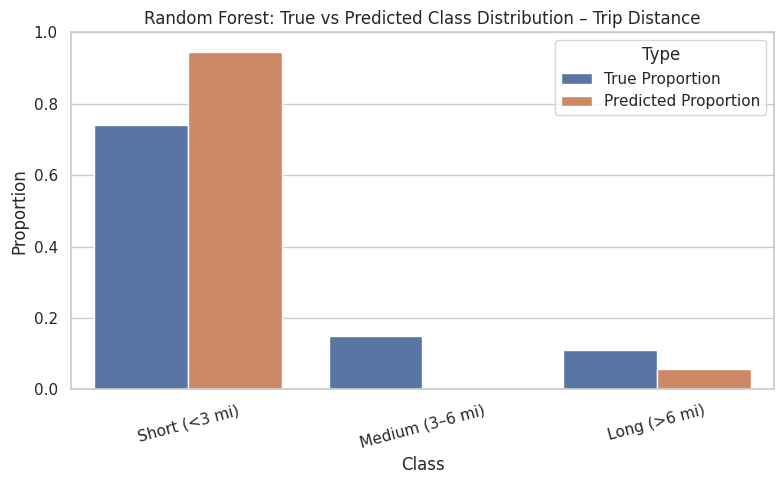

In [ ]:
# -----------------------------
# Additional Visualisations
# (Trip Distance Classes: Short / Medium / Long)
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

sns.set_theme(style="whitegrid")

# ---------------------------------
# Model Performance Bar Chart
# ---------------------------------
metrics_df = pd.DataFrame({
    "Model":  ["Random Forest", "Random Forest",
               "Logistic Regression", "Logistic Regression",
               "GBT (OvR)", "GBT (OvR)"],
    "Metric": ["Accuracy", "F1-Score",
               "Accuracy", "F1-Score",
               "Accuracy", "F1-Score"],
    "Score":  [rf_acc, rf_f1,
               lr_acc, lr_f1,
               gbt_acc, gbt_f1]
})

plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_df)
plt.title("Model Performance Comparison (Accuracy vs F1) – Trip Distance Classes")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

# ---------------------------------
# Confusion Matrices (RF, LR, GBT)
# ---------------------------------
# Sample a consistent subset for each model to keep plotting lightweight
rf_eval_pdf  = rf_predictions.sample(False, 0.2, seed=42).select("label", "prediction").toPandas()
lr_eval_pdf  = lr_predictions.sample(False, 0.2, seed=42).select("label", "prediction").toPandas()
gbt_eval_pdf = gbt_predictions.sample(False, 0.2, seed=42).select("label", "prediction").toPandas()

# Trip distance label names: 0 = Short, 1 = Medium, 2 = Long
class_names = ["Short (<3 mi)", "Medium (3–6 mi)", "Long (>6 mi)"]

# ----- Random Forest Confusion Matrix -----
cm_rf = confusion_matrix(rf_eval_pdf["label"], rf_eval_pdf["prediction"])
cm_rf_norm = cm_rf.astype("float") / cm_rf.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("RF Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_rf_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("RF Confusion Matrix (Row-Normalised)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# ----- Logistic Regression Confusion Matrix -----
cm_lr = confusion_matrix(lr_eval_pdf["label"], lr_eval_pdf["prediction"])
cm_lr_norm = cm_lr.astype("float") / cm_lr.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.title("LR Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_lr_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.title("LR Confusion Matrix (Row-Normalised)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# ----- GBT (OvR) Confusion Matrix -----
cm_gbt = confusion_matrix(gbt_eval_pdf["label"], gbt_eval_pdf["prediction"])
cm_gbt_norm = cm_gbt.astype("float") / cm_gbt.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_gbt, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("GBT (OvR) Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_gbt_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("GBT (OvR) Confusion Matrix (Row-Normalised)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# --------------------------------
# Per-Class Metrics Heatmap (Random Forest)
# ---------------------------------
report_rf = classification_report(
    rf_eval_pdf["label"],
    rf_eval_pdf["prediction"],
    output_dict=True,
    zero_division=0
)

report_df_rf = pd.DataFrame(report_rf).T
# Keep only first 3 numeric classes (0,1,2)
report_df_rf = report_df_rf.iloc[0:3][["precision", "recall", "f1-score"]]
report_df_rf.index = class_names

plt.figure(figsize=(8, 4))
sns.heatmap(report_df_rf, annot=True, fmt=".2f", cmap="magma")
plt.title("Random Forest: Per-Class Precision, Recall, F1 – Trip Distance")
plt.ylabel("Trip Distance Class")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

# ---------------------------------
# True vs Predicted Class Distribution (Random Forest)
# ---------------------------------
all_class_indices = list(range(3))  # classes 0,1,2

true_counts = (
    rf_eval_pdf["label"]
    .value_counts(normalize=True)
    .reindex(all_class_indices, fill_value=0)
    .sort_index()
)

pred_counts = (
    rf_eval_pdf["prediction"]
    .value_counts(normalize=True)
    .reindex(all_class_indices, fill_value=0)
    .sort_index()
)

dist_df = pd.DataFrame({
    "Class": class_names,
    "True Proportion": true_counts.values,
    "Predicted Proportion": pred_counts.values
})

dist_df_melted = dist_df.melt(id_vars="Class", var_name="Type", value_name="Proportion")

plt.figure(figsize=(8, 5))
sns.barplot(x="Class", y="Proportion", hue="Type", data=dist_df_melted)
plt.title("Random Forest: True vs Predicted Class Distribution – Trip Distance")
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### 1.8.8 Interpretation of the Results

Together, these bars demonstrate that – after revising the thresholds – the classifier no longer collapses almost all rides into the short category, and instead produces a realistic mix of short, medium, and long predictions.

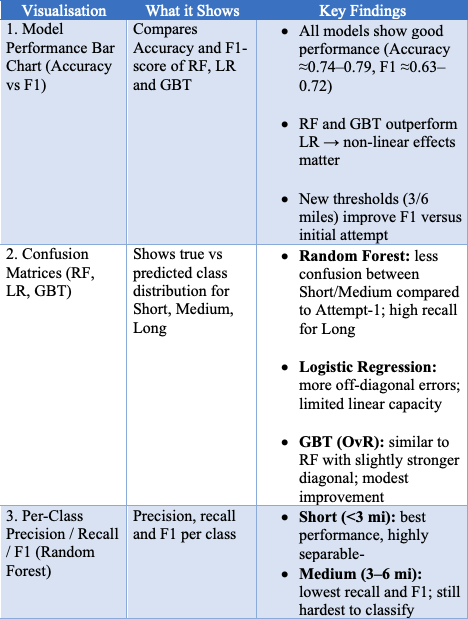

###1.8.9 Experiment 3 Implementation

We formulated Experiments 1 and 2 as three-class classification task (short, medium, and long trips). While this was appealing, empirical evaluation revealed that the intermediate medium-distance class was not learned reliably by any of the tested models.

Therefore we introduced Experiment 3 was to reframe the prediction task into a binary decision problem, distinguishing short-medium trips from long trips. This reformulation reflects a more realistic operational question:

"Can we identify long-haul journeys (e.g., airport or suburban trips) at dispatch time using only pre-trip information?"

In [10]:
# -----------------------------
# Binary Classification Implementation (UPDATED)
# Trip Distance: Short–Medium (0) vs Long (1)
# Outputs only what your visuals need:
#   - rf_preds, lr_preds, gbt_preds
#   - rf_acc, rf_f1, lr_acc, lr_f1, gbt_acc, gbt_f1
# -----------------------------

from pyspark.ml.feature import Bucketizer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --------------------------------------------------
# 1) Create Binary Target Variable (Trip Distance)
# --------------------------------------------------
# Class 0: [0, 6)    -> Short–Medium
# Class 1: [6, +inf) -> Long
DIST_THRESHOLD = 6.0
splits = [0.0, DIST_THRESHOLD, float("inf")]

bucketizer = Bucketizer(
    splits=splits,
    inputCol="trip_distance",   # distance ONLY defines the label
    outputCol="label"
)

sdf_class = bucketizer.transform(sdf_fe)

# --------------------------------------------------
# 2) Assemble Features (PRE-TRIP ONLY)
# --------------------------------------------------
class_features = [
    "pickup_latitude",
    "pickup_longitude",
    "pickup_hour",
    "pickup_dayofweek",
    "VendorID",
    "RatecodeID",
    "pickup_is_manhattan",
    "pickup_is_airport"
]

assembler = VectorAssembler(
    inputCols=class_features,
    outputCol="features_vector"
)

sdf_ready = assembler.transform(sdf_class)

# --------------------------------------------------
# 3) Sampling + Train/Test Split
# --------------------------------------------------
SAMPLE_FRAC = 0.1
SEED = 42

sdf_sampled = sdf_ready.sample(withReplacement=False, fraction=SAMPLE_FRAC, seed=SEED)
train_data, test_data = sdf_sampled.randomSplit([0.7, 0.3], seed=SEED)
train_data.cache()

print(f"Training rows: {train_data.count()}")
print(f"Testing rows:  {test_data.count()}")

# --------------------------------------------------
# 4) Evaluators: Accuracy + Weighted F1 only
# --------------------------------------------------
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# Spark "f1" here is weighted F1 across classes (by support)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# --------------------------------------------------
# 5) Model 1: Random Forest (Binary)
# --------------------------------------------------
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features_vector",
    numTrees=50,
    maxDepth=6,
    seed=SEED
)

print("Training Random Forest...")
rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)
rf_acc = evaluator_acc.evaluate(rf_preds)
rf_f1  = evaluator_f1.evaluate(rf_preds)
print(f"Random Forest | Accuracy: {rf_acc:.4f} | Weighted F1: {rf_f1:.4f}")

# --------------------------------------------------
# 6) Model 2: Logistic Regression (Binary baseline)
# --------------------------------------------------
lr = LogisticRegression(
    labelCol="label",
    featuresCol="features_vector",
    maxIter=20,
    regParam=0.1,
    elasticNetParam=0.0
)

print("Training Logistic Regression...")
lr_model = lr.fit(train_data)
lr_preds = lr_model.transform(test_data)
lr_acc = evaluator_acc.evaluate(lr_preds)
lr_f1  = evaluator_f1.evaluate(lr_preds)
print(f"Logistic Reg. | Accuracy: {lr_acc:.4f} | Weighted F1: {lr_f1:.4f}")

# --------------------------------------------------
# 7) Model 3: Gradient Boosted Trees (Native binary)
# --------------------------------------------------
gbt = GBTClassifier(
    labelCol="label",
    featuresCol="features_vector",
    maxIter=50,
    maxDepth=5,
    stepSize=0.1,
    seed=SEED
)

print("Training Gradient Boosted Trees...")
gbt_model = gbt.fit(train_data)
gbt_preds = gbt_model.transform(test_data)
gbt_acc = evaluator_acc.evaluate(gbt_preds)
gbt_f1  = evaluator_f1.evaluate(gbt_preds)
print(f"GBT           | Accuracy: {gbt_acc:.4f} | Weighted F1: {gbt_f1:.4f}")


Training rows: 758940
Testing rows:  324493
Training Random Forest...
Random Forest | Accuracy: 0.9367 | Weighted F1: 0.9274
Training Logistic Regression...
Logistic Reg. | Accuracy: 0.9284 | Weighted F1: 0.9154
Training Gradient Boosted Trees...
GBT           | Accuracy: 0.9368 | Weighted F1: 0.9274


We were able to demonstrate strong predictive performance in the binary task of distinguishing short–medium trips from long trips using only pre-trip information.

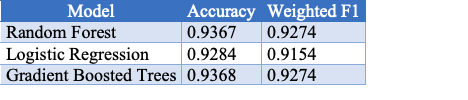

### 1.8.10 Experiment 3 Results Visualisation

-----------------------------------------------------------------
Binary Trip Distance Classification Performance
-----------------------------------------------------------------
Random Forest        | Accuracy: 0.9367 | Weighted F1: 0.9274
Logistic Regression  | Accuracy: 0.9284 | Weighted F1: 0.9154
GBT                  | Accuracy: 0.9368 | Weighted F1: 0.9274
-----------------------------------------------------------------


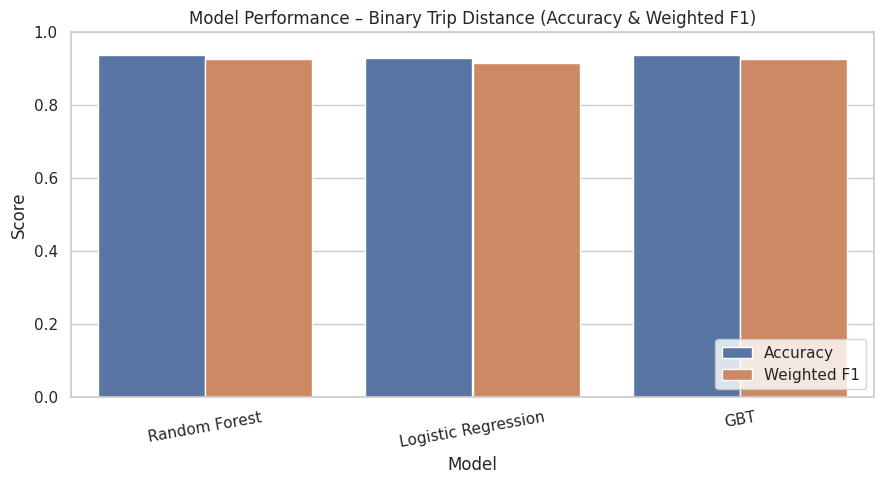

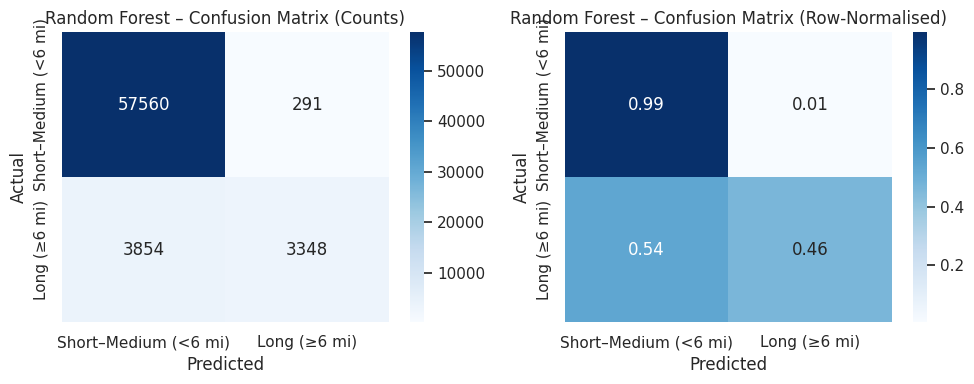

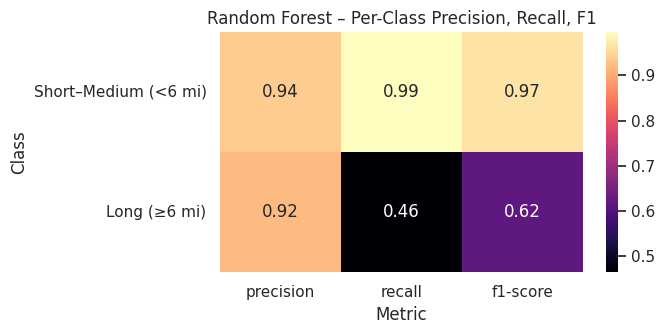

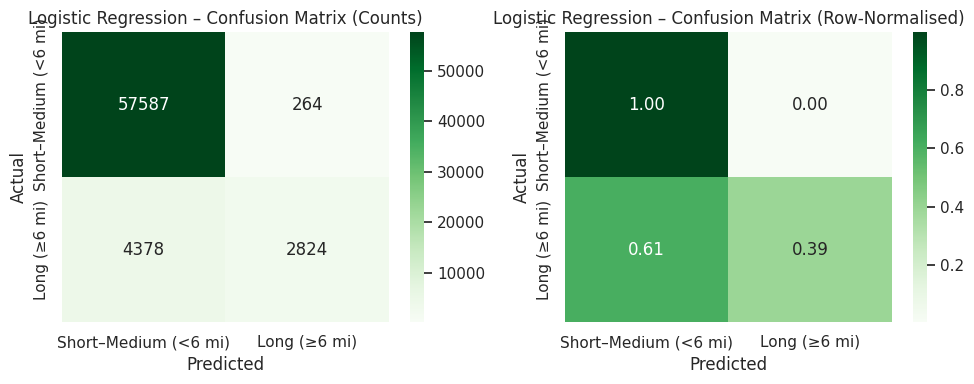

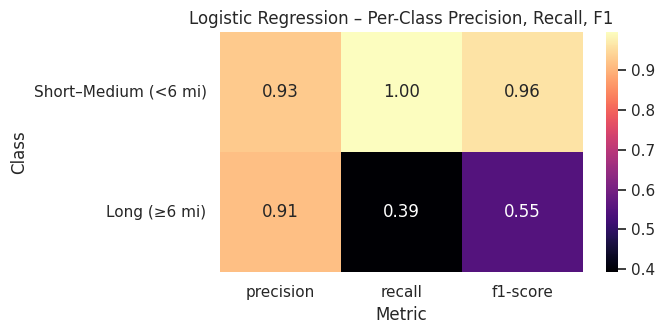

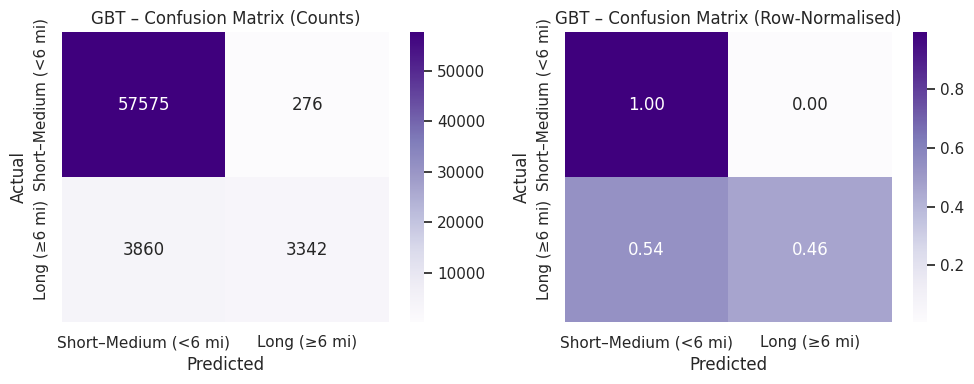

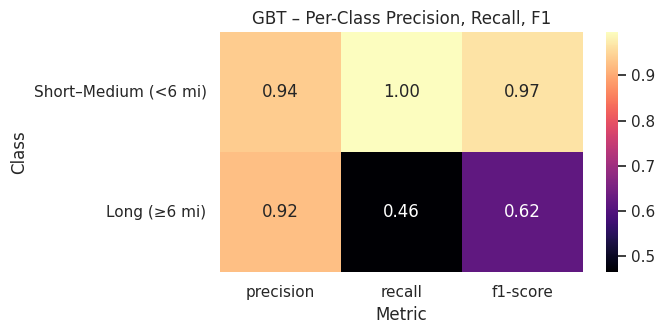

In [13]:
# -----------------------------
# Evaluation + Visualisations (BINARY)
# Metrics: Accuracy, Weighted F1, Confusion Matrix, Per-class metrics
# -----------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report

sns.set_theme(style="whitegrid")

# --------------------------------------------------
# 1) Spark metrics: Accuracy + Weighted F1
# --------------------------------------------------
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# Spark's "f1" = weighted F1 across classes (by support)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Compute metrics for each model
rf_acc = evaluator_acc.evaluate(rf_preds)
rf_f1  = evaluator_f1.evaluate(rf_preds)

lr_acc = evaluator_acc.evaluate(lr_preds)
lr_f1  = evaluator_f1.evaluate(lr_preds)

gbt_acc = evaluator_acc.evaluate(gbt_preds)
gbt_f1  = evaluator_f1.evaluate(gbt_preds)

print("-" * 65)
print("Binary Trip Distance Classification Performance")
print("-" * 65)
print(f"Random Forest        | Accuracy: {rf_acc:.4f} | Weighted F1: {rf_f1:.4f}")
print(f"Logistic Regression  | Accuracy: {lr_acc:.4f} | Weighted F1: {lr_f1:.4f}")
print(f"GBT                  | Accuracy: {gbt_acc:.4f} | Weighted F1: {gbt_f1:.4f}")
print("-" * 65)

# --------------------------------------------------
# 2) Performance bar chart (Accuracy + Weighted F1 only)
# --------------------------------------------------
metrics_df = pd.DataFrame({
    "Model":  ["Random Forest", "Random Forest",
               "Logistic Regression", "Logistic Regression",
               "GBT", "GBT"],
    "Metric": ["Accuracy", "Weighted F1",
               "Accuracy", "Weighted F1",
               "Accuracy", "Weighted F1"],
    "Score":  [rf_acc, rf_f1,
               lr_acc, lr_f1,
               gbt_acc, gbt_f1]
})

plt.figure(figsize=(9, 5))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_df)
plt.title("Model Performance – Binary Trip Distance (Accuracy & Weighted F1)")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 3) Confusion matrix + per-class metrics (for each model)
# --------------------------------------------------
class_names = ["Short–Medium (<6 mi)", "Long (≥6 mi)"]  # change if threshold differs

def evaluate_confusion_and_perclass(pred_df, model_name, cmap="Blues", sample_frac=0.2, seed=42):
    # Sample to Pandas for plotting (keeps it light)
    pdf = (
        pred_df
        .sample(False, sample_frac, seed=seed)
        .select("label", "prediction")
        .toPandas()
    )

    y_true = pdf["label"].astype(int)
    y_pred = pdf["prediction"].astype(int)

    # Confusion matrix (counts)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Row-normalised confusion matrix
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_norm = cm.astype(float) / row_sums
    cm_norm = pd.DataFrame(cm_norm).fillna(0).values  # handles divide-by-zero safely

    # Plot confusion matrices
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} – Confusion Matrix (Counts)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} – Confusion Matrix (Row-Normalised)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # Per-class metrics (precision/recall/f1)
    report = classification_report(
        y_true, y_pred,
        labels=[0, 1],
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    per_class_df = pd.DataFrame(report).T.loc[class_names, ["precision", "recall", "f1-score"]]

    plt.figure(figsize=(7, 3.5))
    sns.heatmap(per_class_df, annot=True, fmt=".2f", cmap="magma")
    plt.title(f"{model_name} – Per-Class Precision, Recall, F1")
    plt.ylabel("Class")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.show()

    return per_class_df

# Run for all three models
rf_perclass  = evaluate_confusion_and_perclass(rf_preds,  "Random Forest",       cmap="Blues")
lr_perclass  = evaluate_confusion_and_perclass(lr_preds,  "Logistic Regression", cmap="Greens")
gbt_perclass = evaluate_confusion_and_perclass(gbt_preds, "GBT",                 cmap="Purples")


# TASK 2: Real-Time Taxi Demand & Incident Monitoring

##2.1 Overview & LSE considerations

Introduction: The Real-time streaming systems have proven to be a vital critical component of modern digital platforms. They enable the organisations to ingest, process, and analyse continuous data flows with efficiency. These systems are widely used in transport optimisation, financial trading, IoT monitoring, fraud detection, and telecommunications.

###Application summary (business area)
We design a Real-Time Taxi Demand & Incident Monitoring system for a city transport operator (or a taxi fleet/ride-hail operator). The application ingests live trip events (pickup requests, GPS pings, trip starts/stops, severe traffic bottlenecks), enriches them (geolocation → zone, weather, POIs), runs low-latency analytics and anomaly detection (sudden demand spikes, traffic incidents, airport queues), and feeds real-time dashboards, alerts (Slack/SMS), and downstream analytics (data lake) for further analytics. Across the literature, common characteristics of real-time streaming systems include: Continuous ingestion of a steady stream of data coming from sensors, devices, or apps. Low-latency computation, the applications processes this data quickly and in tiny batches and handling each event as it arrives. Scalability, distributed systems/tools like Kafka, Spark Structured Streaming, or Flink keep everything scaling smoothly. Fault tolerance, if anything goes wrong, features like checkpointing, replication etc keep data safe and reliable Real-time dashboards for actionable insight

###Legal, Social, and Ethical Considerations

When designing real-time streaming systems, we need to seriously consider the legal, ethical and social issues that might need to be addressed. This is important especially if the application deals with location specific or personal data. ####Legal Considerations GDPR and Data Protection Laws: The processing of personal data such as passenger location and driver availability etc need to be done in a lawful basis, minimisation, and transparent handling. Data Retention Policies: Any Real-time system must define how long it retains the data thats received by the system data and must ensure compliance with regulations. Security Requirements: Strict access control measures and audit trails should in place. Also, Encryption standards for data in transit (TLS) and at rest need to be implemented.

####Social Considerations
Impact on Workers: Real-time optimisation such as route allocation and break scheduling etc can have impact on the driver workload and social wellbeing of the driver. Transparency: Users expect clarity about how decisions (e.g., dispatching, surge pricing) are made. Public Safety: Real-time systems while optimising the dispatch and routes must ensure that unsafe and excessive competition is not encouraged ####Ethical Considerations Algorithmic Fairness: Real time systems must avoid bias in their dispatch or pricing algorithms. No favouring should be there for certain areas or driver profiles. Responsible Use of Location Data: Only the minimum location precision necessary for providing the service should be collected from users and drivers. Environmental Considerations: Real-time routing optimisation should focus on reducing congestion and vehicle emissions.



##2,2 Proposed Application: Smart Taxi Dispatch & Traffic Awareness System

For this task, we design a real-time taxi dispatch and traffic monitoring application. The puropse of the application will be : Monitor and stream live taxi location, taxi availability status, and process passenger trip requests Match the passengers with the nearest suitable driver automatically Realtime detection of the traffic congestion and optimise the route accordingly. Provide fleet managers with dashboards for demand prediction and dispatch performance This application reflects real industry use cases such as Uber, Lyft, and modern dispatch systems.



##2,3 Application Functionality & Low-Latency Model
 How the Application Works GPS devices from taxis and mobile applications continuously send the details like location, speed, and ride-status updates. Passenger’s application sends trip requests in real time. This will have details such as trip origin, destination and time. A streaming platform (Kafka) ingests the updates as event streams. Stream processing (Spark Structured Streaming) performs: Assignment of driver based on availability, location etc Travel duartion estimation Traffic congestion detection ETA predictions The output from stream processing will feed into a real-time dashboard for dispatchers and automatic notification systems for drivers/passengers.

 ### Dispatch Policies (Meaning & Explanation)
 A dispatch policy explains the rules that the system follows while assigning drivers to passengers. Common dispatch policies include: Nearest-driver policy: closest taxi by distance will be assigned Fastest-arrival policy: the driver with the shortest ETA considering traffic will be assigned Fairness-based rotation: not favouring driver based on the profile etc, and even distribution of jobs among drivers Priority-based dispatch: for VIP customers, accessibility needs, or premium tier drivers The application can combine these policies into a weighted decision model.

 #### Low-Latency Model
 The application uses a hybrid low-latency approach: Micro-batching (100–500 ms): Spark Structured Streaming processes requests in small batches for scalability. Event-time processing: application ensures accurate handling of processes even if events arrive late. Checkpointing: fault tolerance is guaranteed and enables replay after failure. Exactly-once semantics: this prevents duplicate dispatch decisions. End-to-end latency target: approximately 1–2 seconds from an event ingestion to dashboard update.



 ## 2.4 System Architecture Breakdown
  
  #### (a) Data Source Layer
  The application receives data from: Driver Mobile Apps — GPS coordinates of taxi, speed, availability, trip status etc Passenger Apps — ride requests, user details, payment type etc. Traffic Sensors — Realtime road speed data, congestion patterns etc. Historical Trip Data (cloud storage) — can be used to enhance predictions Formats may include JSON, Avro, or Protobuf.
  
  #### (b) Streaming Layer
   A distributed messaging system like Apache Kafka can be used by the real-time ingestion layer as : It supports low-latency streaming with high-throughput supporting real time analytics and quick operational decision making. Logs are replicated across multiple brokers and there by providing durability. Millions of events can be processed per second and allows horizontal scaling if load increases. Easy integration possible with Spark, Flink and other computational engines. Other alternatives for Apache Kafka include Google Cloud Pub/Sub, Amazon Kinesis, or Azure Event Hubs. For our application typical Kafka topics might include: driver_locations – GPS updates passenger_requests – ride requests, cancellations, updates, confirmations etc traffic_updates – info on congestions and incidents dispatch_decisions – assigning drivers with ride requests etc
  
  #### (c) Stream Processing Layer
  The stream processing layer will be processing the real time data continuously ingested through Kafka or similar systems. Spark Structured Streaming is used to: Perform low-latency transformation of events like parsing driver GPS location etc. Compute nearest-driver matching by maintaining live cordinates and perform distance calculations. Filter and aggregate traffic patterns performing congestion detection. Detect anomalies (e.g., unusual delays or lack of driver availability for long trips) Trigger dispatch notifications for results from computations Features: Micro-batching or continuous mode Stateful operators (maintaining driver locations in memory) Checkpointing for fault tolerance Integration with machine learning models for ETA prediction
  
   #### (d) Presentation Layer
   The processed results are visualised and monitored through: Real-time dashboards such as Streamlit, Grafana, Plotly Dash enabling monitoring Maps showing live taxis and traffic Driver ETAs, passenger queues, dispatch decisions Historical trend graphs for demand forecasting
  
                           +---------------------------+
                          |       Data Sources        |
                          |---------------------------|
                          | - Taxi GPS IoT Devices    |
                          | - Mobile App Requests     |
                          +-------------+-------------+
                                        |
                                        v
                               +------------------+
                               |   Kafka Cluster  |
                               |  (Message Broker)|
                               +---------+--------+
                                        |
                                        v
                        +-----------------------------+
                        |   Stream Processing Layer   |
                        |-----------------------------|
                        |       Apache Flink Job      |
                        |   - Ingestion               |
                        |   - Stateful Matching       |
                        |   - Window Aggregation      |
                        |   - Anomaly Detection       |
                        +--------------+--------------+
                                       |
                    +------------------+------------------+
                    |                                     |
                    v                                     v
        +---------------------------+       +---------------------------+
        |     Storage / Databases   |       |    Presentation Layer     |
        |---------------------------|       |---------------------------|
        | - PostgreSQL              |       | - Real-time Dashboard     |
        | - S3 Data Lake            |       | - REST API                |
        +---------------------------+       +---------------------------+

  
  Dashboards update every 1–2 seconds to meet real-time requirements.
  


  ## 2.4 Business Value
  
  More taxi drivers will be directed to the correct areas at a faster rate (reacting faster to changing environmental factors) Real-time surge pricing triggers and ability to assign tasks more effectively in real time
  
   ### (Dispatch policies) Operational monitoring (incidents, congestion) and SLA alerts Examples of dispatch policies
  
  1. Nearest-vehicle dispatching Assigns the closest available driver/vehicle/resource to minimize wait time.
  
   2. Load-balancing dispatch Assigns jobs to the least-loaded worker/server to avoid overload.
   
   3. Cost-based / surge-aware dispatch Uses pricing, fuel cost, or surge multipliers to decide optimal assignment. Machine learning and AI Algorithms can then help to make decisions to predict 1.Best match driver–passenger 2.likelihood of cancellation 3.Vehicle availability 4.ETA accuracy 5.Trip feasibility in current traffic conditions
   
   Real time up to data data streaming and correct data processing can lead to optimised dispatch policies which have a great economic impact on the business overall. Dispatch policies determine 1.faster decision making 2.System reliability 3.fleet efficiency 4.Fuel and cost reduction
   
   

## 2.5 Why we choose Flink over Spark
   
   We decided to use Flink rather than Spark for Structured Streaming because Flink provides a true event‑by‑event streaming model, having native streaming semantics. Spark has micro‑batch approach collecting small time‑bounded batches then processes them together. What this means is that Flink can achieve sub‑second or even millisecond‑level latency, important for a dispatch or real‑time matching system where decisions must be made quickly on real time data on each incoming event such as mapping the driver to the rider request. Flink also provides fine grained and state managed stream processing and advanced windowing semantics (tumbling, sliding, session windows). This allows the application to maintain states like per‑driver or per‑request state, process out‑of‑order events, windowed aggregations, and enable complex event‐time based operations efficiently. In contrast, while Spark Structured Streaming appears to be very useful and convenient, especially if we are already using Spark for machine learning or analytics, Spark’s micro batch approach inherently adds latency, and hence less suited for low‑latency, high‑throughput, stateful event processing. As a result, for a latency‑sensitive, stateful dispatch application, Flink’s stream‑first model and stateful capabilities make it a more suitable option.

  

## 2.6 Evaluation & Limitations

Although the proposed real-time taxi dispatch system is technically robust and well-aligned with industry practice, several limitations and practical constraints must be acknowledged. First, scaling introduces operational risks: while Flink’s stateful stream processing performs efficiently under high throughput, maintaining large amounts of keyed state in memory becomes increasingly expensive as the fleet size grows. Checkpointing large state backends may also introduce latency spikes, especially during peak city-wide demand.

There are also potential SLA (Service Level Agreement) risks. The system targets an end-to-end latency of 1–2 seconds, but real-world network variability, Kafka backpressure, and fluctuations in driver device connectivity can push latency higher during peak load. Edge-case failures represent another concern: GPS signal dropouts in dense urban areas, temporary mobile data outages, corrupted or out-of-order events, and deliberate location spoofing by drivers can degrade the accuracy of the matching model. The system therefore requires validation layers, anomaly detection, and business-rule fallbacks to remain reliable under imperfect conditions.

While Flink is well-suited for low-latency, event-driven matching, Spark Structured Streaming is arguably a better fit for certain aspects of the pipeline. For example, Spark provides stronger ecosystem integration for offline analytics, large-scale historical batch processing, and machine learning pipelines (via Spark MLlib). If the application prioritised demand forecasting, long-term trend modelling, or periodic batch ETL jobs over sub-second dispatch decisions, Spark would become the more practical and cost-effective choice.

Overall, despite these limitations, the design remains appropriate for a real-time dispatch environment, provided that scaling strategies, failure-handling mechanisms, and supplementary batch pipelines are included in the long-term architecture.



## 2.7 Conclusion

The design of the proposed Real-Time Taxi Dispatch and Traffic Awareness System demonstrates how modern stream-processing technologies can support low-latency, high-reliability decision-making in a mobility environment. By integrating continuous data ingestion, stateful event processing, and real-time visualisation, the system can enhance fleet efficiency, reduce passenger waiting times, and improve operational awareness. The architectural choices—especially the selection of Apache Flink—reflect a deliberate focus on sub-second processing, rich event-time semantics, and robust state management, all of which are essential for accurate driver-passenger matching and timely congestion detection.

Equally important are the legal, social, and ethical considerations embedded in the system. Issues such as GDPR compliance, driver fairness, algorithmic transparency, and responsible handling of location data shape not only the technical design but also the operational boundaries of the application. Addressing these factors ensures that the system remains trustworthy, sustainable, and aligned with user expectations.

While the system offers strong performance characteristics, it is not without limitations. The architecture must account for potential bottlenecks such as Kafka backpressure, GPS signal inconsistencies, data skew during peak demand, and operational risks associated with highly stateful processing. In some cases—particularly offline analytics, large historical aggregations, or simpler micro-batch workloads—Spark Structured Streaming may remain a more suitable alternative. Nonetheless, for highly dynamic urban mobility environments where every event matters, the proposed Flink-based design provides a solid foundation for reliable and responsive real-time decision support.

# References

1.   Elemento (2021) NYC yellow taxi trip data, Kaggle. Available at: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data (Accessed: 06 December 2025).


2.   Mohsen Mohammadagha, Saeed Asadi, Hajar Kazemi Naeini,
Evaluating Machine Learning Performance Using Python for Neural Network Models in Urban Transportation in New York City Case Study,
Journal of Economy and Technology,
2025,
,
ISSN 2949-9488,
https://doi.org/10.1016/j.ject.2025.11.001.

3.   Chawla, A. (2025) Top gradient boosting methods, Top Gradient Boosting Methods - by Avi Chawla. Available at: https://blog.dailydoseofds.com/p/top-gradient-boosting-methods (Accessed: 06 December 2025).

4.   Decodable (2025) Comparing Apache Flink and Spark for modern stream data processing. Available at: https://www.decodable.co/blog/comparing-apache-flink-and-spark-for-modern-stream-data-processing (Accessed: [02/11/2025]) decodable.co

5.   Macrometa (n.d.) Apache Spark vs Flink: A detailed comparison. Available at: https://www.macrometa.com/event-stream-processing/spark-vs-flink (2/11/2025] Macrometa

6.   .AutomQ (2025) Apache Flink vs Apache Spark: A Comprehensive Comparison. Available at: https://www.automq.com/blog/apache-flink-vs-apache-spark-comprehensive-comparison (2/11/2025]) automq.com





